This Notebook uses MLBAM data from 2021 to predict sequences of pitch types. A deep learning architecture known as an encoder-decoder will be used for this purpose. 

# Pre-processing

Data is split into training and test data. Any plate appearance after July is a part of the test set. Basic features such as balls, strikes, pitcher and batter handedness, release speed, and pitcher will be used to fit the encoder-decoder.

In [1]:
# Import required packages
import numpy as np
from numpy import array
from numpy import hstack
from numpy import vstack

import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband
import kerastuner

In [2]:
# Load raw pitch data with pybaseball
from pybaseball import statcast
df = statcast(start_dt='2021-04-01', end_dt='2021-10-03')

C:\Users\jacobmo\Miniconda3\envs\tf\lib\site-packages\pybaseball\statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


This is a large query, it may take a moment to complete


100%|████████████████████████████████████████████████████████████████████████████████| 186/186 [00:53<00:00,  3.48it/s]


In [3]:
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [4]:
# Include only regular season games
df = df.loc[df['game_type']=='R'].copy()
df.reset_index(drop=True, inplace=True)

# Create unique ID for every plate appearance in every game
df['pa_id'] = df['game_pk'].astype(str)+"-"+df['at_bat_number'].astype(str)

# Fill in the occasional missing value;
# WOBA values should only be missing for pitches that are NOT the final pitch
df['release_speed'].fillna(0, inplace=True)
df['woba_value'].fillna(0, inplace=True)

# Create dictionary to re-group pitch types
pitch_dict = {'FF':0, 'FA':0,
              'FT':1, 'SI':1,
              'FC':2,
              'CU':3,'KC':3,'CS':3,'EP':3,
              'SL':4,
              'CH':5,'FS':5,'FO':5,'SC':5,
              'KN':6,
              'PO':np.nan}

# Map old pitch types to new mapping
df['pitch_type_map'] = df['pitch_type'].map(pitch_dict)
df.dropna(subset=['pitch_type_map'], inplace = True)
df['pitch_type_copy'] = df['pitch_type_map']

df = pd.get_dummies(df, columns=['pitcher','p_throws','stand','pitch_type_map',
                                 'balls','strikes'])

In [5]:
# Only include plate appearances that last at least 3 pitches
data = df[df.groupby('pa_id')['pa_id'].transform('size') >= 3].copy()
data.reset_index(drop=True, inplace=True)

In [6]:
# Function to split data into training and test data after preparing features
def data_splitter(data_seq, train_test_cutoff):
        
    train = data_seq.loc[data['game_date'] <= train_test_cutoff].copy()
    train.reset_index(drop=True, inplace=True)
    test = data.loc[data_seq['game_date'] > train_test_cutoff].copy()
    test.reset_index(drop=True, inplace=True)
    
    train.sort_values(by=['pa_id','pitch_number'],inplace=True, ignore_index=True)
    test.sort_values(by=['pa_id','pitch_number'],inplace=True, ignore_index=True)
    
    y_train = np.array(train['pitch_type_copy'])
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = np.array(test['pitch_type_copy'])
    y_test = tf.keras.utils.to_categorical(y_test)

    scaler = StandardScaler()

    pa_id_train = train.pa_id.values.reshape((len(train['pa_id']),1))
    pa_id_test = test.pa_id.values.reshape((len(test['pa_id']),1))

    pitch_velo_train = train.release_speed.values.reshape((len(train['release_speed']),1))
    pitch_velo_train = scaler.fit_transform(pitch_velo_train)
    pitch_velo_test = test.release_speed.values.reshape((len(test['release_speed']),1))
    pitch_velo_test = scaler.transform(pitch_velo_test)
    
    pitcher_train = array(train.loc[:,train.columns.str.startswith('pitcher_')])
    pitcher_test = array(test.loc[:, test.columns.str.startswith('pitcher_')])

    p_throws_train = array(train.loc[:,train.columns.str.startswith('p_throws_')])
    p_throws_test = array(test.loc[:, test.columns.str.startswith('p_throws_')])

    stand_train = array(train.loc[:,train.columns.str.startswith('stand_')])
    stand_test = array(test.loc[:, test.columns.str.startswith('stand_')])
    
    pitch_type_train = array(train.loc[:,train.columns.str.startswith('pitch_type_map_')])
    pitch_type_test = array(test.loc[:, test.columns.str.startswith('pitch_type_map_')])

    balls_train = array(train.loc[:,train.columns.str.startswith('balls_')])
    strikes_train = array(train.loc[:, train.columns.str.startswith('strikes_')])
    balls_test = array(test.loc[:, test.columns.str.startswith('balls_')])
    strikes_test = array(test.loc[:, test.columns.str.startswith('strikes_')])

    #Combine all features
    x_train = hstack((pa_id_train, pitch_velo_train, pitch_type_train, balls_train, strikes_train,
                      pitcher_train, p_throws_train, stand_train))
    x_test = hstack((pa_id_test, pitch_velo_test, pitch_type_test, balls_test, strikes_test, 
                     pitcher_test, p_throws_test, stand_test))
    
    # Store number of features that are not known before pitch is thrown
    future_vars = pitch_velo_train.shape[1]+pitch_type_train.shape[1]
    
    return y_train, y_test, x_train, x_test, future_vars 

In [7]:
# Function to take raw data in order and convert it into a 3D array
def seq_prepper(data, sequences, y, n_latent_only, n_steps_in, n_steps_out):
    
    input_, output, decoder_input = list(), list(), list()
    woba_tracker = list()
    running_ix = 0
    out_end_ix = 0
    # Loop over each plate appearance and build a sequence
    while out_end_ix < len(sequences):
        temp_pa_id = sequences[running_ix,0]
        obs = len(sequences[sequences[:,0] == temp_pa_id])
        pa_woba = data.loc[data['pa_id'] == temp_pa_id, 'woba_value'].max()
        end_ix = running_ix + obs - n_steps_out
        out_end_ix = running_ix + obs
        # Break loop if index becomes longer than length of original dataset
        if out_end_ix > len(sequences): break
        
        seq_all = sequences[running_ix:end_ix, 1:]
            
        seq_out = y[end_ix:out_end_ix, :]

        seq_train_decoder = sequences[end_ix:out_end_ix, n_latent_only+1:]
        # Make balls-strikes unknown after first pitch in sequence...
        # Equivalent to setting get_dummies columns to 0
        seq_train_decoder[1:, :7] = 0
        
        # Pad sequences to be uniform in length
        padded_all = tf.keras.preprocessing.sequence.pad_sequences([seq_all], 
                                                                   maxlen = n_steps_in,
                                                                   padding = 'pre',
                                                                   truncating = 'pre',
                                                                   value = -100.,
                                                                   dtype='float32')
        
        padded_all = array(padded_all).reshape((n_steps_in, (sequences.shape[1]-1)))
        
        input_.append(padded_all)
        output.append(seq_out)
        decoder_input.append(seq_train_decoder)
        woba_tracker.append(pa_woba)
            
        running_ix += obs
            
    input0 = np.array(input_)
    output0 = np.array(output)
    decoder_input = np.array(decoder_input)
    
    input0 = input0.astype(np.float32)
    output0 = np.array(output0).astype(np.float32)
    decoder_input = decoder_input.astype(np.float32)
    
    woba = np.array(woba_tracker)
    
    return input0, output0, decoder_input, woba

In [8]:
# Create training and test sets
cutoff_date = '2021-07-31'
y_train, y_test, x_train, x_test, n_future_vars = data_splitter(data, cutoff_date)

# Format data for encoder-decoder
# Predict two steps ahead, and pad sequences to max length based on the longest PA in training set
n_steps_out = 2
n_steps_in = df.loc[df['game_date']<=cutoff_date].groupby(['pa_id']).size().max() - n_steps_out

encoder_input, decoder_output, decoder_input, woba = seq_prepper(data, 
                                                                 x_train, 
                                                                 y_train,
                                                                 n_future_vars, 
                                                                 n_steps_in, 
                                                                 n_steps_out)

encoder_test, decoder_otest, decoder_itest, woba_test = seq_prepper(data, 
                                                                    x_test, 
                                                                    y_test,
                                                                    n_future_vars, 
                                                                    n_steps_in, 
                                                                    n_steps_out)

# Encoder-Decoder

In [9]:
num_input_features = encoder_input.shape[2] # Number of encoder features
num_decoder_inputs = decoder_input.shape[2] # Number of decoder features
n_ptypes = decoder_output.shape[2] # Number of pitch types

batch_size = encoder_input.shape[0] # Number of sequences
input_sequence_length = n_steps_in # Length of the sequence used by the encoder

In [10]:
def model_builder(hp):


    # First branch of the net is an lstm which finds an embedding for the past
    past_inputs = tf.keras.Input(shape=(None,num_input_features), 
                                 name='past_inputs')

    # Mask inputs with values of -100
    masking = tf.keras.layers.Masking(mask_value= -100.,
                                      input_shape=(n_steps_in, num_input_features))(past_inputs)

    # Number of units to search for in each LSTM/dense layer
    n_units = hp.Int('units', min_value=36, max_value=96, step=12)
    
    # L2 regularizer for the encoder and decoder
    regularizer = tf.keras.regularizers.l2(0.01)
    
    # Encode the past
    encoder1 = tf.keras.layers.LSTM(n_units, return_state=True,
                                    return_sequences=True, 
                                    kernel_regularizer=regularizer)
    
    encoder_outputs1, state_h1, state_c1 = encoder1(masking)

    enc_drop = tf.keras.layers.Dropout(rate=0.1)(encoder_outputs1)

    encoder2 = tf.keras.layers.LSTM(n_units,return_sequences=True,
                                    return_state=True, 
                                    kernel_regularizer=regularizer)
    
    encoder_outputs2, state_h2, state_c2 = encoder2(enc_drop)

    future_inputs = tf.keras.Input(
        shape=(None, num_decoder_inputs), name='future_inputs')

    # Decoder
    decoder_lstm = tf.keras.layers.LSTM(n_units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        kernel_regularizer=regularizer)
    
    x, dec_h, dec_c = decoder_lstm(future_inputs,
                                   initial_state=[state_h2, state_c2])

    # Attention layer
    att = tf.keras.layers.Attention()([x,encoder_outputs2])
    out = tf.keras.layers.Concatenate(axis=-1)([x, att])

    decoder_dense_a = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_ptypes, activation='softmax'))
    
    output_a = decoder_dense_a(out)

    model = tf.keras.models.Model(
        inputs=[past_inputs, future_inputs], outputs=output_a)
    
    learning_rate = hp.Choice('learning_rate', values=[1e-1,1e-2,1e-3])
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [11]:
# Hyperband tuner with early stopping built to minimize loss function
tuner = Hyperband(model_builder,
                     objective=kerastuner.Objective('val_loss', direction='min'),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='kt314')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [12]:
# Search over 25 epochs
tuner.search([encoder_input,decoder_input],
             decoder_output, 
             epochs=30, 
             validation_split=0.2, 
             callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Epoch 1/2


 614/2149 [=======>......................] - ETA: 0s - loss: 11.89 - ETA: 38s - loss: 8.72 - ETA: 49s - loss: 6.69 - ETA: 56s - loss: 5.49 - ETA: 1:00 - loss: 4.826 - ETA: 1:01 - loss: 4.431 - ETA: 1:03 - loss: 4.172 - ETA: 1:04 - loss: 3.970 - ETA: 1:04 - loss: 3.776 - ETA: 1:07 - loss: 3.601 - ETA: 1:07 - loss: 3.440 - ETA: 1:08 - loss: 3.313 - ETA: 1:09 - loss: 3.201 - ETA: 1:09 - loss: 3.109 - ETA: 1:11 - loss: 3.071 - ETA: 1:10 - loss: 2.995 - ETA: 1:11 - loss: 2.921 - ETA: 1:11 - loss: 2.858 - ETA: 1:12 - loss: 2.796 - ETA: 1:13 - loss: 2.740 - ETA: 1:13 - loss: 2.692 - ETA: 1:13 - loss: 2.644 - ETA: 1:13 - loss: 2.602 - ETA: 1:14 - loss: 2.560 - ETA: 1:13 - loss: 2.523 - ETA: 1:14 - loss: 2.487 - ETA: 1:14 - loss: 2.456 - ETA: 1:14 - loss: 2.421 - ETA: 1:14 - loss: 2.389 - ETA: 1:14 - loss: 2.368 - ETA: 1:14 - loss: 2.344 - ETA: 1:14 - loss: 2.323 - ETA: 1:14 - loss: 2.303 - ETA: 1:15 - loss: 2.295 - ETA: 1:14 - loss: 2.275 - ETA: 1:15 - loss: 2.268 - ETA: 1:15 - loss: 2.253 - E

1285/2149 [================>.............] - ETA: 56s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 56s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.68 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 55s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 54s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.67 - ETA: 53s - loss: 1.

1940/2149 [==========================>...] - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 30s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 29s - loss: 1.60 - ETA: 28s - loss: 1.60 - ETA: 28s - loss: 1.60 - ETA: 28s - loss: 1.60 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.579 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 7s - loss: 1.578 - ETA: 6s - loss: 1.578 - ETA: 6s - loss: 1.578 - ETA: 6s - loss: 1.578 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 6s - loss: 1.577 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.577 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 5s - loss: 1.576 - ETA: 4s - loss: 1.576 - ETA: 4s - loss: 1.5

 647/2149 [========>.....................] - ETA: 0s - loss: 1.678 - ETA: 38s - loss: 1.56 - ETA: 52s - loss: 1.52 - ETA: 55s - loss: 1.53 - ETA: 57s - loss: 1.51 - ETA: 57s - loss: 1.52 - ETA: 58s - loss: 1.52 - ETA: 1:00 - loss: 1.528 - ETA: 1:02 - loss: 1.522 - ETA: 1:03 - loss: 1.524 - ETA: 1:03 - loss: 1.530 - ETA: 1:04 - loss: 1.526 - ETA: 1:04 - loss: 1.526 - ETA: 1:04 - loss: 1.527 - ETA: 1:05 - loss: 1.528 - ETA: 1:05 - loss: 1.526 - ETA: 1:05 - loss: 1.528 - ETA: 1:06 - loss: 1.526 - ETA: 1:07 - loss: 1.521 - ETA: 1:07 - loss: 1.527 - ETA: 1:07 - loss: 1.529 - ETA: 1:07 - loss: 1.529 - ETA: 1:07 - loss: 1.530 - ETA: 1:07 - loss: 1.535 - ETA: 1:07 - loss: 1.535 - ETA: 1:07 - loss: 1.539 - ETA: 1:07 - loss: 1.537 - ETA: 1:07 - loss: 1.539 - ETA: 1:07 - loss: 1.538 - ETA: 1:07 - loss: 1.535 - ETA: 1:07 - loss: 1.535 - ETA: 1:07 - loss: 1.529 - ETA: 1:07 - loss: 1.529 - ETA: 1:07 - loss: 1.529 - ETA: 1:07 - loss: 1.527 - ETA: 1:07 - loss: 1.523 - ETA: 1:07 - loss: 1.523 - ETA: 1:

1326/2149 [=================>............] - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 50s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 48s - loss: 1.

2000/2149 [==========================>...] - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.50 - ETA: 24s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 3s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.504 - ETA: 2s - loss: 1.5

Epoch 1/2


 639/2149 [=======>......................] - ETA: 0s - loss: 13.15 - ETA: 45s - loss: 17.121 - ETA: 51s - loss: 16.041 - ETA: 55s - loss: 14.458 - ETA: 55s - loss: 13.769 - ETA: 57s - loss: 12.490 - ETA: 59s - loss: 11.758 - ETA: 58s - loss: 10.986 - ETA: 1:01 - loss: 10.26 - ETA: 1:00 - loss: 9.7281 - ETA: 1:01 - loss: 9.187 - ETA: 1:03 - loss: 8.730 - ETA: 1:04 - loss: 8.320 - ETA: 1:04 - loss: 7.945 - ETA: 1:04 - loss: 7.601 - ETA: 1:05 - loss: 7.295 - ETA: 1:05 - loss: 7.006 - ETA: 1:06 - loss: 6.749 - ETA: 1:06 - loss: 6.515 - ETA: 1:06 - loss: 6.298 - ETA: 1:07 - loss: 6.102 - ETA: 1:07 - loss: 5.919 - ETA: 1:07 - loss: 5.750 - ETA: 1:08 - loss: 5.595 - ETA: 1:08 - loss: 5.447 - ETA: 1:08 - loss: 5.311 - ETA: 1:08 - loss: 5.183 - ETA: 1:08 - loss: 5.064 - ETA: 1:09 - loss: 4.953 - ETA: 1:09 - loss: 4.850 - ETA: 1:09 - loss: 4.752 - ETA: 1:08 - loss: 4.660 - ETA: 1:09 - loss: 4.573 - ETA: 1:09 - loss: 4.487 - ETA: 1:09 - loss: 4.410 - ETA: 1:09 - loss: 4.337 - ETA: 1:09 - loss: 4.

1312/2149 [=================>............] - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 52s - loss: 2.21 - ETA: 51s - loss: 2.21 - ETA: 51s - loss: 2.21 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.20 - ETA: 51s - loss: 2.19 - ETA: 51s - loss: 2.19 - ETA: 51s - loss: 2.19 - ETA: 51s - loss: 2.19 - ETA: 51s - loss: 2.19 - ETA: 51s - loss: 2.19 - ETA: 50s - loss: 2.19 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.18 - ETA: 50s - loss: 2.17 - ETA: 50s - loss: 2.

1985/2149 [==========================>...] - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 29s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 28s - loss: 1.94 - ETA: 27s - loss: 1.94 - ETA: 27s - loss: 1.94 - ETA: 27s - loss: 1.94 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 27s - loss: 1.93 - ETA: 26s - loss: 1.93 - ETA: 26s - loss: 1.93 - ETA: 26s - loss: 1.93 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.868 - ETA: 5s - loss: 1.867 - ETA: 5s - loss: 1.867 - ETA: 5s - loss: 1.867 - ETA: 5s - loss: 1.867 - ETA: 4s - loss: 1.867 - ETA: 4s - loss: 1.867 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.866 - ETA: 4s - loss: 1.865 - ETA: 4s - loss: 1.865 - ETA: 4s - loss: 1.865 - ETA: 4s - loss: 1.865 - ETA: 3s - loss: 1.865 - ETA: 3s - loss: 1.865 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.864 - ETA: 3s - loss: 1.863 - ETA: 3s - loss: 1.863 - ETA: 3s - loss: 1.863 - ETA: 3s - loss: 1.863 - ETA: 3s - loss: 1.863 - ETA: 3s - loss: 1.8

 637/2149 [=======>......................] - ETA: 0s - loss: 1.716 - ETA: 46s - loss: 1.75 - ETA: 53s - loss: 1.71 - ETA: 1:02 - loss: 1.697 - ETA: 1:05 - loss: 1.694 - ETA: 1:06 - loss: 1.705 - ETA: 1:08 - loss: 1.703 - ETA: 1:09 - loss: 1.715 - ETA: 1:11 - loss: 1.707 - ETA: 1:11 - loss: 1.709 - ETA: 1:11 - loss: 1.707 - ETA: 1:13 - loss: 1.706 - ETA: 1:13 - loss: 1.710 - ETA: 1:12 - loss: 1.712 - ETA: 1:12 - loss: 1.713 - ETA: 1:12 - loss: 1.715 - ETA: 1:13 - loss: 1.711 - ETA: 1:13 - loss: 1.714 - ETA: 1:12 - loss: 1.715 - ETA: 1:13 - loss: 1.716 - ETA: 1:13 - loss: 1.715 - ETA: 1:13 - loss: 1.715 - ETA: 1:13 - loss: 1.718 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.718 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.719 - ETA: 1:13 - loss: 1.717 - ETA: 1:13 - loss: 1.710 - ETA: 1:13 - loss: 1.710 - ETA: 1:13 - loss: 1.712 - ETA: 1:13 - loss: 1.710 - ETA: 1:13 - loss: 1.711 - ETA: 1:12 - loss: 1.710 - ETA: 1:12 - loss: 1.709 - ETA: 1:13 - loss: 1.711 - ETA: 1:12 - loss: 1.712 -

1311/2149 [=================>............] - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 52s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 51s - loss: 1.71 - ETA: 50s - loss: 1.71 - ETA: 50s - loss: 1.71 - ETA: 50s - loss: 1.71 - ETA: 50s - loss: 1.

1989/2149 [==========================>...] - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.70 - ETA: 27s - loss: 1.70 - ETA: 27s - loss: 1.70 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 5s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 4s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 3s - loss: 1.710 - ETA: 2s - loss: 1.710 - ETA: 2s - loss: 1.710 - ETA: 2s - loss: 1.7

Epoch 1/2


 965/2149 [============>.................] - ETA: 0s - loss: 7.489 - ETA: 33s - loss: 8.24 - ETA: 35s - loss: 7.42 - ETA: 38s - loss: 6.50 - ETA: 37s - loss: 5.58 - ETA: 37s - loss: 5.15 - ETA: 38s - loss: 4.66 - ETA: 38s - loss: 4.36 - ETA: 38s - loss: 4.12 - ETA: 38s - loss: 3.92 - ETA: 39s - loss: 3.80 - ETA: 40s - loss: 3.64 - ETA: 40s - loss: 3.49 - ETA: 40s - loss: 3.37 - ETA: 40s - loss: 3.27 - ETA: 41s - loss: 3.20 - ETA: 41s - loss: 3.11 - ETA: 41s - loss: 3.03 - ETA: 41s - loss: 2.96 - ETA: 41s - loss: 2.90 - ETA: 41s - loss: 2.84 - ETA: 41s - loss: 2.79 - ETA: 41s - loss: 2.74 - ETA: 41s - loss: 2.70 - ETA: 41s - loss: 2.65 - ETA: 41s - loss: 2.63 - ETA: 41s - loss: 2.59 - ETA: 41s - loss: 2.56 - ETA: 42s - loss: 2.53 - ETA: 41s - loss: 2.50 - ETA: 42s - loss: 2.49 - ETA: 42s - loss: 2.46 - ETA: 41s - loss: 2.43 - ETA: 42s - loss: 2.41 - ETA: 42s - loss: 2.39 - ETA: 42s - loss: 2.38 - ETA: 42s - loss: 2.36 - ETA: 41s - loss: 2.34 - ETA: 42s - loss: 2.32 - ETA: 41s - loss: 2.

1926/2149 [=========================>....] - ETA: 25s - loss: 1.75 - ETA: 25s - loss: 1.75 - ETA: 25s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 24s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 23s - loss: 1.75 - ETA: 22s - loss: 1.75 - ETA: 22s - loss: 1.75 - ETA: 22s - loss: 1.75 - ETA: 22s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.727 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.728 - ETA: 4s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.728 - ETA: 3s - loss: 1.727 - ETA: 3s - loss: 1.727 - ETA: 3s - loss: 1.727 - ETA: 3s - loss: 1.727 - ETA: 3s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.727 - ETA: 2s - loss: 1.7

1003/2149 [=============>................] - ETA: 0s - loss: 1.772 - ETA: 33s - loss: 1.68 - ETA: 35s - loss: 1.69 - ETA: 39s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 39s - loss: 1.69 - ETA: 41s - loss: 1.68 - ETA: 41s - loss: 1.67 - ETA: 40s - loss: 1.68 - ETA: 41s - loss: 1.68 - ETA: 41s - loss: 1.68 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.68 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.69 - ETA: 42s - loss: 1.69 - ETA: 42s - loss: 1.69 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 42s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.68 - ETA: 41s - loss: 1.69 - ETA: 41s - loss: 1.

1951/2149 [==========================>...] - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 22s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.71 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.719 - ETA: 4s - loss: 1.719 - ETA: 4s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 3s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 2s - loss: 1.719 - ETA: 1s - loss: 1.719 - ETA: 1s - loss: 1.719 - ETA: 1s - loss: 1.718 - ETA: 1s - loss: 1.718 - ETA: 1s - loss: 1.718 - ETA: 1s - loss: 1.7

Epoch 1/2


 668/2149 [========>.....................] - ETA: 0s - loss: 11.86 - ETA: 44s - loss: 17.115 - ETA: 49s - loss: 15.463 - ETA: 53s - loss: 13.573 - ETA: 55s - loss: 12.504 - ETA: 55s - loss: 10.994 - ETA: 57s - loss: 10.386 - ETA: 57s - loss: 9.670 - ETA: 58s - loss: 9.13 - ETA: 59s - loss: 8.65 - ETA: 1:00 - loss: 8.200 - ETA: 1:02 - loss: 7.813 - ETA: 1:02 - loss: 7.455 - ETA: 1:03 - loss: 7.133 - ETA: 1:03 - loss: 6.839 - ETA: 1:04 - loss: 6.578 - ETA: 1:04 - loss: 6.338 - ETA: 1:05 - loss: 6.117 - ETA: 1:05 - loss: 5.916 - ETA: 1:06 - loss: 5.732 - ETA: 1:06 - loss: 5.559 - ETA: 1:06 - loss: 5.402 - ETA: 1:07 - loss: 5.252 - ETA: 1:07 - loss: 5.115 - ETA: 1:07 - loss: 4.986 - ETA: 1:07 - loss: 4.872 - ETA: 1:07 - loss: 4.760 - ETA: 1:07 - loss: 4.657 - ETA: 1:07 - loss: 4.560 - ETA: 1:07 - loss: 4.472 - ETA: 1:07 - loss: 4.388 - ETA: 1:06 - loss: 4.305 - ETA: 1:07 - loss: 4.230 - ETA: 1:07 - loss: 4.161 - ETA: 1:06 - loss: 4.094 - ETA: 1:07 - loss: 4.028 - ETA: 1:06 - loss: 3.969 - 

1350/2149 [=================>............] - ETA: 47s - loss: 1.94 - ETA: 47s - loss: 1.94 - ETA: 46s - loss: 1.94 - ETA: 46s - loss: 1.94 - ETA: 46s - loss: 1.94 - ETA: 46s - loss: 1.94 - ETA: 46s - loss: 1.94 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.93 - ETA: 46s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.91 - ETA: 44s - loss: 1.91 - ETA: 44s - loss: 1.91 - ETA: 44s - loss: 1.91 - ETA: 44s - loss: 1.91 - ETA: 44s - loss: 1.91 - ETA: 44s - loss: 1.

2035/2149 [===========================>..] - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 25s - loss: 1.81 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 24s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.80 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 3s - loss: 1.775 - ETA: 3s - loss: 1.775 - ETA: 3s - loss: 1.775 - ETA: 3s - loss: 1.775 - ETA: 3s - loss: 1.774 - ETA: 3s - loss: 1.774 - ETA: 3s - loss: 1.774 - ETA: 3s - loss: 1.774 - ETA: 3s - loss: 1.774 - ETA: 2s - loss: 1.774 - ETA: 2s - loss: 1.774 - ETA: 2s - loss: 1.774 - ETA: 2s - loss: 1.774 - ETA: 2s - loss: 1.774 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 2s - loss: 1.773 - ETA: 1s - loss: 1.773 - ETA: 1s - loss: 1.773 - ETA: 1s - loss: 1.773 - ETA: 1s - loss: 1.773 - ETA: 1s - loss: 1.773 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.772 - ETA: 1s - loss: 1.771 - ETA: 0s - loss: 1.7

 679/2149 [========>.....................] - ETA: 0s - loss: 1.666 - ETA: 38s - loss: 1.67 - ETA: 52s - loss: 1.68 - ETA: 53s - loss: 1.67 - ETA: 57s - loss: 1.66 - ETA: 57s - loss: 1.66 - ETA: 58s - loss: 1.67 - ETA: 59s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 1:00 - loss: 1.695 - ETA: 1:00 - loss: 1.704 - ETA: 1:00 - loss: 1.709 - ETA: 1:00 - loss: 1.716 - ETA: 1:00 - loss: 1.718 - ETA: 1:00 - loss: 1.721 - ETA: 1:01 - loss: 1.720 - ETA: 1:01 - loss: 1.719 - ETA: 1:01 - loss: 1.718 - ETA: 1:02 - loss: 1.719 - ETA: 1:02 - loss: 1.722 - ETA: 1:02 - loss: 1.720 - ETA: 1:03 - loss: 1.717 - ETA: 1:03 - loss: 1.716 - ETA: 1:03 - loss: 1.715 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.716 - ETA: 1:03 - loss: 1.713 - ETA: 1:03 - loss: 1.708 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.710 - ETA: 1:03 - loss: 1.711 - ETA: 1:02 - loss: 1.709 - ETA: 1:03 - loss: 1.710 - ETA: 1:03 - loss: 1.710 - ETA: 1:02 - loss: 1.710 - ETA: 1:02 - loss: 1.710 - ETA: 1:03 - l

1372/2149 [==================>...........] - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 45s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 44s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 43s - loss: 1.70 - ETA: 42s - loss: 1.

2063/2149 [===========================>..] - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 23s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 22s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.70 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 2s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 1s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.705 - ETA: 0s - loss: 1.7

Epoch 1/2


 656/2149 [========>.....................] - ETA: 0s - loss: 11.87 - ETA: 44s - loss: 11.481 - ETA: 46s - loss: 10.913 - ETA: 49s - loss: 10.553 - ETA: 52s - loss: 10.211 - ETA: 53s - loss: 9.882 - ETA: 53s - loss: 9.40 - ETA: 55s - loss: 9.11 - ETA: 56s - loss: 8.83 - ETA: 57s - loss: 8.55 - ETA: 58s - loss: 8.30 - ETA: 58s - loss: 8.05 - ETA: 58s - loss: 7.82 - ETA: 59s - loss: 7.59 - ETA: 1:00 - loss: 7.383 - ETA: 1:00 - loss: 7.183 - ETA: 1:01 - loss: 6.994 - ETA: 1:02 - loss: 6.810 - ETA: 1:02 - loss: 6.632 - ETA: 1:02 - loss: 6.466 - ETA: 1:03 - loss: 6.310 - ETA: 1:03 - loss: 6.159 - ETA: 1:04 - loss: 6.019 - ETA: 1:05 - loss: 5.877 - ETA: 1:05 - loss: 5.750 - ETA: 1:05 - loss: 5.628 - ETA: 1:05 - loss: 5.513 - ETA: 1:05 - loss: 5.400 - ETA: 1:05 - loss: 5.292 - ETA: 1:05 - loss: 5.192 - ETA: 1:05 - loss: 5.096 - ETA: 1:05 - loss: 5.008 - ETA: 1:05 - loss: 4.926 - ETA: 1:05 - loss: 4.841 - ETA: 1:05 - loss: 4.761 - ETA: 1:05 - loss: 4.685 - ETA: 1:05 - loss: 4.610 - ETA: 1:05 - 

1337/2149 [=================>............] - ETA: 49s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.94 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.93 - ETA: 48s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.92 - ETA: 47s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 47s - loss: 1.91 - ETA: 46s - loss: 1.91 - ETA: 46s - loss: 1.91 - ETA: 46s - loss: 1.91 - ETA: 46s - loss: 1.91 - ETA: 46s - loss: 1.90 - ETA: 46s - loss: 1.90 - ETA: 46s - loss: 1.90 - ETA: 46s - loss: 1.90 - ETA: 46s - loss: 1.

2015/2149 [===========================>..] - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.71 - ETA: 26s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 25s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.71 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.637 - ETA: 4s - loss: 1.637 - ETA: 4s - loss: 1.637 - ETA: 4s - loss: 1.636 - ETA: 4s - loss: 1.636 - ETA: 4s - loss: 1.636 - ETA: 4s - loss: 1.636 - ETA: 3s - loss: 1.636 - ETA: 3s - loss: 1.636 - ETA: 3s - loss: 1.635 - ETA: 3s - loss: 1.635 - ETA: 3s - loss: 1.635 - ETA: 3s - loss: 1.635 - ETA: 3s - loss: 1.635 - ETA: 3s - loss: 1.634 - ETA: 3s - loss: 1.634 - ETA: 3s - loss: 1.634 - ETA: 3s - loss: 1.634 - ETA: 3s - loss: 1.634 - ETA: 3s - loss: 1.633 - ETA: 3s - loss: 1.633 - ETA: 3s - loss: 1.633 - ETA: 2s - loss: 1.633 - ETA: 2s - loss: 1.633 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.632 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 2s - loss: 1.631 - ETA: 1s - loss: 1.630 - ETA: 1s - loss: 1.630 - ETA: 1s - loss: 1.6

 661/2149 [========>.....................] - ETA: 0s - loss: 1.394 - ETA: 38s - loss: 1.51 - ETA: 47s - loss: 1.54 - ETA: 52s - loss: 1.55 - ETA: 56s - loss: 1.52 - ETA: 58s - loss: 1.52 - ETA: 58s - loss: 1.51 - ETA: 59s - loss: 1.50 - ETA: 1:00 - loss: 1.515 - ETA: 1:00 - loss: 1.522 - ETA: 1:00 - loss: 1.518 - ETA: 1:01 - loss: 1.510 - ETA: 1:02 - loss: 1.509 - ETA: 1:01 - loss: 1.515 - ETA: 1:02 - loss: 1.519 - ETA: 1:02 - loss: 1.513 - ETA: 1:03 - loss: 1.507 - ETA: 1:03 - loss: 1.504 - ETA: 1:03 - loss: 1.505 - ETA: 1:04 - loss: 1.503 - ETA: 1:04 - loss: 1.503 - ETA: 1:04 - loss: 1.506 - ETA: 1:04 - loss: 1.506 - ETA: 1:04 - loss: 1.498 - ETA: 1:04 - loss: 1.492 - ETA: 1:04 - loss: 1.487 - ETA: 1:04 - loss: 1.485 - ETA: 1:04 - loss: 1.486 - ETA: 1:04 - loss: 1.485 - ETA: 1:04 - loss: 1.486 - ETA: 1:04 - loss: 1.485 - ETA: 1:04 - loss: 1.486 - ETA: 1:04 - loss: 1.483 - ETA: 1:04 - loss: 1.486 - ETA: 1:05 - loss: 1.488 - ETA: 1:05 - loss: 1.489 - ETA: 1:04 - loss: 1.490 - ETA: 1:04

1340/2149 [=================>............] - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.

2023/2149 [===========================>..] - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 3s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 2s - loss: 1.424 - ETA: 1s - loss: 1.424 - ETA: 1s - loss: 1.424 - ETA: 1s - loss: 1.424 - ETA: 1s - loss: 1.424 - ETA: 1s - loss: 1.424 - ETA: 1s - loss: 1.423 - ETA: 1s - loss: 1.423 - ETA: 1s - loss: 1.4

Epoch 1/2


 583/2149 [=======>......................] - ETA: 0s - loss: 13.13 - ETA: 51s - loss: 12.681 - ETA: 54s - loss: 12.031 - ETA: 57s - loss: 11.620 - ETA: 1:00 - loss: 11.22 - ETA: 1:01 - loss: 10.85 - ETA: 1:05 - loss: 10.48 - ETA: 1:06 - loss: 10.14 - ETA: 1:09 - loss: 9.8139 - ETA: 1:08 - loss: 9.497 - ETA: 1:11 - loss: 9.347 - ETA: 1:11 - loss: 9.049 - ETA: 1:13 - loss: 8.774 - ETA: 1:13 - loss: 8.507 - ETA: 1:14 - loss: 8.376 - ETA: 1:15 - loss: 8.123 - ETA: 1:16 - loss: 7.886 - ETA: 1:17 - loss: 7.773 - ETA: 1:16 - loss: 7.552 - ETA: 1:17 - loss: 7.352 - ETA: 1:17 - loss: 7.251 - ETA: 1:18 - loss: 7.059 - ETA: 1:18 - loss: 6.879 - ETA: 1:18 - loss: 6.709 - ETA: 1:19 - loss: 6.628 - ETA: 1:19 - loss: 6.468 - ETA: 1:20 - loss: 6.314 - ETA: 1:19 - loss: 6.170 - ETA: 1:20 - loss: 6.103 - ETA: 1:20 - loss: 5.968 - ETA: 1:19 - loss: 5.840 - ETA: 1:20 - loss: 5.781 - ETA: 1:19 - loss: 5.662 - ETA: 1:19 - loss: 5.547 - ETA: 1:20 - loss: 5.494 - ETA: 1:20 - loss: 5.389 - ETA: 1:20 - loss: 5.

1229/2149 [================>.............] - ETA: 1:00 - loss: 2.037 - ETA: 1:00 - loss: 2.036 - ETA: 1:00 - loss: 2.035 - ETA: 1:00 - loss: 2.033 - ETA: 1:00 - loss: 2.032 - ETA: 1:00 - loss: 2.031 - ETA: 1:00 - loss: 2.030 - ETA: 1:00 - loss: 2.029 - ETA: 59s - loss: 2.027 - ETA: 59s - loss: 2.02 - ETA: 59s - loss: 2.02 - ETA: 59s - loss: 2.02 - ETA: 59s - loss: 2.02 - ETA: 59s - loss: 2.02 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 59s - loss: 2.01 - ETA: 58s - loss: 2.01 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 2.00 - ETA: 58s - loss: 1.99 - ETA: 58s - loss: 1.99 - ETA: 58s - loss: 1.99 - ETA: 58s - loss: 1.99 - ETA: 58s - loss: 1.99 - ETA: 57s - loss: 1.99 - ETA: 57s - loss: 1.99 - ETA: 57s - loss: 1.99 - ETA: 57s - loss: 1.98 - ET

1874/2149 [=========================>....] - ETA: 35s - loss: 1.76 - ETA: 35s - loss: 1.76 - ETA: 35s - loss: 1.76 - ETA: 35s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 34s - loss: 1.76 - ETA: 33s - loss: 1.76 - ETA: 33s - loss: 1.76 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 33s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.75 - ETA: 32s - loss: 1.

2149/2149 [==============================] - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 9s - loss: 1.6646 - ETA: 9s - loss: 1.664 - ETA: 9s - loss: 1.664 - ETA: 9s - loss: 1.664 - ETA: 9s - loss: 1.663 - ETA: 9s - loss: 1.663 - ETA: 9s - loss: 1.663 - ETA: 9s - loss: 1.663 - ETA: 9s - loss: 1.662 - ETA: 9s - loss: 1.662 - ETA: 9s - loss: 1.662 - ETA: 9s - loss: 1.662 - ETA: 9s - loss: 1.662 - ETA: 8s - loss: 1.662 - ETA: 8s - loss: 1.661 - ETA: 8s - loss: 1.661 - ETA: 8s - loss: 1.661 - ETA: 8s - loss: 1.661 - ETA: 8s - loss: 1.661 - ETA: 8s - loss: 1.660 - ETA: 8s - loss: 1.660 - ETA: 8s - loss: 1.660 - ETA: 8s - loss: 1.660 - ETA: 8s - loss: 1.660 - ETA: 8s - loss: 1.659 - ETA: 8s - loss: 1.659 - ETA: 7s - loss: 1.659 - ETA: 7s - loss: 1.659 - ETA: 7s - loss: 1.658 - ETA: 7s - loss: 1.658 - ETA: 7s - loss: 1.

 634/2149 [=======>......................] - ETA: 0s - loss: 1.466 - ETA: 49s - loss: 1.52 - ETA: 59s - loss: 1.51 - ETA: 1:01 - loss: 1.476 - ETA: 1:04 - loss: 1.481 - ETA: 1:05 - loss: 1.472 - ETA: 1:05 - loss: 1.467 - ETA: 1:06 - loss: 1.464 - ETA: 1:07 - loss: 1.459 - ETA: 1:09 - loss: 1.443 - ETA: 1:09 - loss: 1.438 - ETA: 1:09 - loss: 1.434 - ETA: 1:09 - loss: 1.434 - ETA: 1:10 - loss: 1.437 - ETA: 1:10 - loss: 1.434 - ETA: 1:12 - loss: 1.439 - ETA: 1:12 - loss: 1.443 - ETA: 1:12 - loss: 1.446 - ETA: 1:13 - loss: 1.451 - ETA: 1:13 - loss: 1.446 - ETA: 1:13 - loss: 1.443 - ETA: 1:13 - loss: 1.442 - ETA: 1:13 - loss: 1.436 - ETA: 1:13 - loss: 1.436 - ETA: 1:13 - loss: 1.437 - ETA: 1:13 - loss: 1.435 - ETA: 1:13 - loss: 1.435 - ETA: 1:13 - loss: 1.438 - ETA: 1:13 - loss: 1.437 - ETA: 1:13 - loss: 1.436 - ETA: 1:13 - loss: 1.436 - ETA: 1:13 - loss: 1.435 - ETA: 1:13 - loss: 1.435 - ETA: 1:13 - loss: 1.434 - ETA: 1:13 - loss: 1.431 - ETA: 1:13 - loss: 1.431 - ETA: 1:13 - loss: 1.432 -

1305/2149 [=================>............] - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 54s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 53s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.44 - ETA: 52s - loss: 1.44 - ETA: 52s - loss: 1.44 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.

1975/2149 [==========================>...] - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 30s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.

2149/2149 [==============================] - ETA: 6s - loss: 1.422 - ETA: 6s - loss: 1.422 - ETA: 6s - loss: 1.422 - ETA: 6s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.422 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.422 - ETA: 3s - loss: 1.4

Epoch 1/2


 675/2149 [========>.....................] - ETA: 0s - loss: 10.52 - ETA: 36s - loss: 6.83 - ETA: 46s - loss: 5.50 - ETA: 49s - loss: 4.72 - ETA: 51s - loss: 4.10 - ETA: 51s - loss: 3.89 - ETA: 52s - loss: 3.72 - ETA: 53s - loss: 3.54 - ETA: 54s - loss: 3.39 - ETA: 55s - loss: 3.24 - ETA: 55s - loss: 3.12 - ETA: 56s - loss: 3.03 - ETA: 56s - loss: 2.94 - ETA: 57s - loss: 2.86 - ETA: 57s - loss: 2.80 - ETA: 57s - loss: 2.74 - ETA: 58s - loss: 2.68 - ETA: 58s - loss: 2.63 - ETA: 58s - loss: 2.58 - ETA: 59s - loss: 2.55 - ETA: 59s - loss: 2.51 - ETA: 59s - loss: 2.47 - ETA: 1:00 - loss: 2.447 - ETA: 1:00 - loss: 2.415 - ETA: 1:00 - loss: 2.387 - ETA: 1:00 - loss: 2.361 - ETA: 1:01 - loss: 2.335 - ETA: 1:01 - loss: 2.312 - ETA: 1:00 - loss: 2.291 - ETA: 1:01 - loss: 2.272 - ETA: 1:01 - loss: 2.250 - ETA: 1:01 - loss: 2.232 - ETA: 1:01 - loss: 2.215 - ETA: 1:01 - loss: 2.200 - ETA: 1:01 - loss: 2.184 - ETA: 1:01 - loss: 2.171 - ETA: 1:01 - loss: 2.154 - ETA: 1:01 - loss: 2.142 - ETA: 1:01 -

1360/2149 [=================>............] - ETA: 45s - loss: 1.66 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 45s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.65 - ETA: 44s - loss: 1.64 - ETA: 44s - loss: 1.64 - ETA: 44s - loss: 1.64 - ETA: 44s - loss: 1.64 - ETA: 44s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.64 - ETA: 43s - loss: 1.

2049/2149 [===========================>..] - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 24s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 23s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 22s - loss: 1.59 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 3s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 2s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 1s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.566 - ETA: 0s - loss: 1.5

 736/2149 [=========>....................] - ETA: 0s - loss: 1.542 - ETA: 38s - loss: 1.51 - ETA: 49s - loss: 1.46 - ETA: 51s - loss: 1.47 - ETA: 52s - loss: 1.48 - ETA: 53s - loss: 1.48 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 55s - loss: 1.49 - ETA: 55s - loss: 1.50 - ETA: 55s - loss: 1.49 - ETA: 56s - loss: 1.49 - ETA: 56s - loss: 1.48 - ETA: 56s - loss: 1.48 - ETA: 56s - loss: 1.48 - ETA: 57s - loss: 1.48 - ETA: 56s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.50 - ETA: 57s - loss: 1.50 - ETA: 57s - loss: 1.50 - ETA: 57s - loss: 1.50 - ETA: 57s - loss: 1.50 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.49 - ETA: 57s - loss: 1.

1470/2149 [===================>..........] - ETA: 40s - loss: 1.50 - ETA: 40s - loss: 1.50 - ETA: 40s - loss: 1.50 - ETA: 40s - loss: 1.50 - ETA: 40s - loss: 1.50 - ETA: 40s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 39s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 19s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 18s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 17s - loss: 1.50 - ETA: 16s - loss: 1.50 - ETA: 16s - loss: 1.

Epoch 1/2


 593/2149 [=======>......................] - ETA: 0s - loss: 13.12 - ETA: 44s - loss: 9.47 - ETA: 49s - loss: 7.18 - ETA: 56s - loss: 5.85 - ETA: 58s - loss: 5.11 - ETA: 1:01 - loss: 4.691 - ETA: 1:03 - loss: 4.421 - ETA: 1:03 - loss: 4.196 - ETA: 1:04 - loss: 3.983 - ETA: 1:05 - loss: 3.791 - ETA: 1:07 - loss: 3.610 - ETA: 1:07 - loss: 3.459 - ETA: 1:08 - loss: 3.334 - ETA: 1:09 - loss: 3.230 - ETA: 1:10 - loss: 3.140 - ETA: 1:10 - loss: 3.058 - ETA: 1:11 - loss: 2.985 - ETA: 1:11 - loss: 2.918 - ETA: 1:12 - loss: 2.857 - ETA: 1:13 - loss: 2.802 - ETA: 1:12 - loss: 2.751 - ETA: 1:13 - loss: 2.728 - ETA: 1:13 - loss: 2.678 - ETA: 1:14 - loss: 2.661 - ETA: 1:14 - loss: 2.620 - ETA: 1:15 - loss: 2.580 - ETA: 1:14 - loss: 2.548 - ETA: 1:15 - loss: 2.516 - ETA: 1:15 - loss: 2.485 - ETA: 1:15 - loss: 2.458 - ETA: 1:15 - loss: 2.434 - ETA: 1:15 - loss: 2.410 - ETA: 1:15 - loss: 2.386 - ETA: 1:15 - loss: 2.364 - ETA: 1:15 - loss: 2.345 - ETA: 1:15 - loss: 2.327 - ETA: 1:15 - loss: 2.308 - ETA

1250/2149 [================>.............] - ETA: 1:00 - loss: 1.699 - ETA: 1:00 - loss: 1.698 - ETA: 1:00 - loss: 1.698 - ETA: 1:00 - loss: 1.697 - ETA: 1:00 - loss: 1.697 - ETA: 1:00 - loss: 1.696 - ETA: 1:00 - loss: 1.696 - ETA: 1:00 - loss: 1.696 - ETA: 1:00 - loss: 1.695 - ETA: 1:00 - loss: 1.694 - ETA: 1:00 - loss: 1.694 - ETA: 1:00 - loss: 1.694 - ETA: 1:00 - loss: 1.693 - ETA: 59s - loss: 1.692 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.69 - ETA: 59s - loss: 1.68 - ETA: 59s - loss: 1.68 - ETA: 59s - loss: 1.68 - ETA: 59s - loss: 1.68 - ETA: 59s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss:

1894/2149 [=========================>....] - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 34s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 33s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 32s - loss: 1.61 - ETA: 31s - loss: 1.61 - ETA: 31s - loss: 1.

2149/2149 [==============================] - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.582 - ETA: 9s - loss: 1.581 - ETA: 9s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.581 - ETA: 8s - loss: 1.580 - ETA: 8s - loss: 1.580 - ETA: 8s - loss: 1.580 - ETA: 8s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.579 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.580 - ETA: 7s - loss: 1.579 - ETA: 7s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.5

 617/2149 [=======>......................] - ETA: 0s - loss: 1.361 - ETA: 38s - loss: 1.48 - ETA: 52s - loss: 1.47 - ETA: 1:01 - loss: 1.466 - ETA: 1:04 - loss: 1.488 - ETA: 1:05 - loss: 1.494 - ETA: 1:08 - loss: 1.516 - ETA: 1:09 - loss: 1.511 - ETA: 1:09 - loss: 1.515 - ETA: 1:09 - loss: 1.508 - ETA: 1:11 - loss: 1.506 - ETA: 1:11 - loss: 1.510 - ETA: 1:11 - loss: 1.514 - ETA: 1:12 - loss: 1.519 - ETA: 1:12 - loss: 1.518 - ETA: 1:13 - loss: 1.514 - ETA: 1:13 - loss: 1.516 - ETA: 1:13 - loss: 1.521 - ETA: 1:13 - loss: 1.523 - ETA: 1:13 - loss: 1.527 - ETA: 1:14 - loss: 1.523 - ETA: 1:13 - loss: 1.523 - ETA: 1:14 - loss: 1.524 - ETA: 1:14 - loss: 1.529 - ETA: 1:13 - loss: 1.527 - ETA: 1:14 - loss: 1.525 - ETA: 1:14 - loss: 1.524 - ETA: 1:13 - loss: 1.522 - ETA: 1:14 - loss: 1.524 - ETA: 1:14 - loss: 1.531 - ETA: 1:14 - loss: 1.535 - ETA: 1:14 - loss: 1.533 - ETA: 1:14 - loss: 1.535 - ETA: 1:14 - loss: 1.535 - ETA: 1:14 - loss: 1.533 - ETA: 1:14 - loss: 1.534 - ETA: 1:14 - loss: 1.533 -

1280/2149 [================>.............] - ETA: 56s - loss: 1.51 - ETA: 56s - loss: 1.51 - ETA: 56s - loss: 1.51 - ETA: 56s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 55s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 54s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.51 - ETA: 53s - loss: 1.

1951/2149 [==========================>...] - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 29s - loss: 1.51 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.509 - ETA: 7s - loss: 1.508 - ETA: 7s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 6s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 5s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.508 - ETA: 4s - loss: 1.5

Epoch 1/2


 816/2149 [==========>...................] - ETA: 0s - loss: 9.074 - ETA: 35s - loss: 8.80 - ETA: 39s - loss: 8.41 - ETA: 43s - loss: 8.16 - ETA: 43s - loss: 7.81 - ETA: 43s - loss: 7.48 - ETA: 44s - loss: 7.27 - ETA: 44s - loss: 6.97 - ETA: 45s - loss: 6.78 - ETA: 45s - loss: 6.51 - ETA: 45s - loss: 6.33 - ETA: 46s - loss: 6.17 - ETA: 46s - loss: 5.95 - ETA: 46s - loss: 5.74 - ETA: 47s - loss: 5.60 - ETA: 47s - loss: 5.41 - ETA: 47s - loss: 5.24 - ETA: 47s - loss: 5.07 - ETA: 47s - loss: 4.97 - ETA: 48s - loss: 4.87 - ETA: 48s - loss: 4.78 - ETA: 48s - loss: 4.65 - ETA: 48s - loss: 4.56 - ETA: 48s - loss: 4.44 - ETA: 48s - loss: 4.34 - ETA: 48s - loss: 4.27 - ETA: 48s - loss: 4.17 - ETA: 49s - loss: 4.07 - ETA: 48s - loss: 3.99 - ETA: 49s - loss: 3.94 - ETA: 48s - loss: 3.85 - ETA: 48s - loss: 3.81 - ETA: 49s - loss: 3.76 - ETA: 49s - loss: 3.70 - ETA: 49s - loss: 3.65 - ETA: 49s - loss: 3.59 - ETA: 49s - loss: 3.55 - ETA: 49s - loss: 3.50 - ETA: 48s - loss: 3.45 - ETA: 48s - loss: 3.

1700/2149 [======================>.......] - ETA: 34s - loss: 1.80 - ETA: 34s - loss: 1.80 - ETA: 34s - loss: 1.80 - ETA: 34s - loss: 1.80 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 34s - loss: 1.79 - ETA: 33s - loss: 1.79 - ETA: 33s - loss: 1.79 - ETA: 33s - loss: 1.79 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 33s - loss: 1.78 - ETA: 32s - loss: 1.78 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 32s - loss: 1.77 - ETA: 31s - loss: 1.

2149/2149 [==============================] - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 11s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 10s - loss: 1.63 - ETA: 9s - loss: 1.6319 - ETA: 9s - loss: 1.631 - ETA: 9s - loss: 1.631 - ETA: 9s - loss: 1.631 - ETA: 9s - loss: 1.630 - ETA: 9s - loss: 1.630 - ETA: 9s - loss: 1.630 - ETA: 9s - loss: 1.630 - ETA: 9s - loss: 1.629 - ETA: 9s - loss: 1.629 - ETA: 9s - loss: 1.629 - ETA: 9s - loss: 1.629 - ETA: 9s - loss: 1.628 - ETA: 9s - loss: 1.628 - ETA: 9s - loss: 1.628 - ETA: 8s - loss: 1.628 - ETA: 8s - loss: 1.628 - ETA: 8s - loss: 1.627 - ETA: 8s - loss: 1.

 906/2149 [===========>..................] - ETA: 0s - loss: 1.482 - ETA: 33s - loss: 1.47 - ETA: 40s - loss: 1.47 - ETA: 41s - loss: 1.46 - ETA: 43s - loss: 1.47 - ETA: 44s - loss: 1.46 - ETA: 44s - loss: 1.47 - ETA: 44s - loss: 1.47 - ETA: 46s - loss: 1.46 - ETA: 46s - loss: 1.46 - ETA: 45s - loss: 1.46 - ETA: 46s - loss: 1.45 - ETA: 47s - loss: 1.46 - ETA: 47s - loss: 1.45 - ETA: 47s - loss: 1.46 - ETA: 47s - loss: 1.46 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.46 - ETA: 48s - loss: 1.46 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.44 - ETA: 49s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 49s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.45 - ETA: 48s - loss: 1.46 - ETA: 48s - loss: 1.

1820/2149 [========================>.....] - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.43 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 7s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 6s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.429 - ETA: 5s - loss: 1.428 - ETA: 5s - loss: 1.428 - ETA: 5s - loss: 1.4

Epoch 1/2


 949/2149 [============>.................] - ETA: 0s - loss: 7.507 - ETA: 34s - loss: 7.20 - ETA: 35s - loss: 6.90 - ETA: 39s - loss: 6.63 - ETA: 37s - loss: 6.29 - ETA: 39s - loss: 6.05 - ETA: 40s - loss: 5.82 - ETA: 39s - loss: 5.61 - ETA: 40s - loss: 5.41 - ETA: 41s - loss: 5.29 - ETA: 41s - loss: 5.11 - ETA: 41s - loss: 4.95 - ETA: 42s - loss: 4.84 - ETA: 42s - loss: 4.69 - ETA: 42s - loss: 4.55 - ETA: 43s - loss: 4.47 - ETA: 43s - loss: 4.34 - ETA: 43s - loss: 4.26 - ETA: 43s - loss: 4.15 - ETA: 43s - loss: 4.05 - ETA: 44s - loss: 3.99 - ETA: 44s - loss: 3.90 - ETA: 44s - loss: 3.84 - ETA: 44s - loss: 3.76 - ETA: 44s - loss: 3.69 - ETA: 44s - loss: 3.62 - ETA: 44s - loss: 3.55 - ETA: 44s - loss: 3.48 - ETA: 44s - loss: 3.44 - ETA: 44s - loss: 3.39 - ETA: 44s - loss: 3.33 - ETA: 44s - loss: 3.28 - ETA: 44s - loss: 3.23 - ETA: 44s - loss: 3.21 - ETA: 44s - loss: 3.16 - ETA: 44s - loss: 3.12 - ETA: 44s - loss: 3.08 - ETA: 44s - loss: 3.05 - ETA: 44s - loss: 3.01 - ETA: 44s - loss: 2.

1906/2149 [=========================>....] - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 25s - loss: 1.74 - ETA: 25s - loss: 1.74 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.618 - ETA: 5s - loss: 1.618 - ETA: 5s - loss: 1.618 - ETA: 5s - loss: 1.617 - ETA: 5s - loss: 1.617 - ETA: 5s - loss: 1.617 - ETA: 5s - loss: 1.617 - ETA: 5s - loss: 1.617 - ETA: 4s - loss: 1.617 - ETA: 4s - loss: 1.616 - ETA: 4s - loss: 1.616 - ETA: 4s - loss: 1.616 - ETA: 4s - loss: 1.616 - ETA: 4s - loss: 1.616 - ETA: 4s - loss: 1.615 - ETA: 4s - loss: 1.615 - ETA: 4s - loss: 1.615 - ETA: 4s - loss: 1.615 - ETA: 4s - loss: 1.615 - ETA: 4s - loss: 1.614 - ETA: 4s - loss: 1.614 - ETA: 4s - loss: 1.614 - ETA: 4s - loss: 1.614 - ETA: 4s - loss: 1.613 - ETA: 3s - loss: 1.613 - ETA: 3s - loss: 1.613 - ETA: 3s - loss: 1.613 - ETA: 3s - loss: 1.613 - ETA: 3s - loss: 1.612 - ETA: 3s - loss: 1.612 - ETA: 3s - loss: 1.612 - ETA: 3s - loss: 1.611 - ETA: 3s - loss: 1.611 - ETA: 3s - loss: 1.611 - ETA: 3s - loss: 1.611 - ETA: 3s - loss: 1.610 - ETA: 3s - loss: 1.610 - ETA: 3s - loss: 1.610 - ETA: 3s - loss: 1.610 - ETA: 2s - loss: 1.6

 959/2149 [============>.................] - ETA: 0s - loss: 1.460 - ETA: 33s - loss: 1.46 - ETA: 35s - loss: 1.43 - ETA: 39s - loss: 1.45 - ETA: 40s - loss: 1.47 - ETA: 39s - loss: 1.46 - ETA: 40s - loss: 1.46 - ETA: 41s - loss: 1.46 - ETA: 42s - loss: 1.45 - ETA: 42s - loss: 1.45 - ETA: 41s - loss: 1.45 - ETA: 42s - loss: 1.45 - ETA: 42s - loss: 1.45 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.46 - ETA: 42s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.47 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 42s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 43s - loss: 1.46 - ETA: 42s - loss: 1.

1914/2149 [=========================>....] - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.435 - ETA: 2s - loss: 1.4

Epoch 1/2


 589/2149 [=======>......................] - ETA: 0s - loss: 14.34 - ETA: 44s - loss: 10.236 - ETA: 50s - loss: 7.703 - ETA: 56s - loss: 6.23 - ETA: 1:02 - loss: 5.444 - ETA: 1:04 - loss: 5.010 - ETA: 1:05 - loss: 4.724 - ETA: 1:06 - loss: 4.476 - ETA: 1:08 - loss: 4.246 - ETA: 1:11 - loss: 4.132 - ETA: 1:11 - loss: 3.934 - ETA: 1:12 - loss: 3.753 - ETA: 1:14 - loss: 3.671 - ETA: 1:15 - loss: 3.535 - ETA: 1:16 - loss: 3.417 - ETA: 1:16 - loss: 3.320 - ETA: 1:16 - loss: 3.229 - ETA: 1:17 - loss: 3.188 - ETA: 1:17 - loss: 3.106 - ETA: 1:18 - loss: 3.030 - ETA: 1:17 - loss: 2.962 - ETA: 1:18 - loss: 2.900 - ETA: 1:18 - loss: 2.843 - ETA: 1:18 - loss: 2.793 - ETA: 1:19 - loss: 2.768 - ETA: 1:19 - loss: 2.720 - ETA: 1:20 - loss: 2.678 - ETA: 1:20 - loss: 2.659 - ETA: 1:20 - loss: 2.622 - ETA: 1:20 - loss: 2.587 - ETA: 1:20 - loss: 2.555 - ETA: 1:20 - loss: 2.524 - ETA: 1:20 - loss: 2.494 - ETA: 1:20 - loss: 2.468 - ETA: 1:20 - loss: 2.445 - ETA: 1:21 - loss: 2.418 - ETA: 1:21 - loss: 2.395 

1214/2149 [===============>..............] - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.712 - ETA: 1:03 - loss: 1.711 - ETA: 1:03 - loss: 1.711 - ETA: 1:02 - loss: 1.711 - ETA: 1:02 - loss: 1.710 - ETA: 1:02 - loss: 1.710 - ETA: 1:02 - loss: 1.709 - ETA: 1:02 - loss: 1.708 - ETA: 1:02 - loss: 1.707 - ETA: 1:02 - loss: 1.707 - ETA: 1:02 - loss: 1.706 - ETA: 1:02 - loss: 1.706 - ETA: 1:02 - loss: 1.705 - ETA: 1:02 - loss: 1.705 - ETA: 1:02 - loss: 1.704 - ETA: 1:02 - loss: 1.704 - ETA: 1:01 - loss: 1.703 - ETA: 1:01 - loss: 1.703 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.702 - ETA: 1:01 - loss: 1.701 - ETA: 1:01 - loss: 1.701 - ETA: 1:01 - loss: 1.701 - ETA: 1:00 - loss: 1.701 - ETA: 1:00 - loss: 1.701 - ETA: 1:00 - loss: 1.701 - ETA: 1:00 - loss: 1

1845/2149 [========================>.....] - ETA: 38s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 37s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 36s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.64 - ETA: 35s - loss: 1.63 - ETA: 35s - loss: 1.63 - ETA: 35s - loss: 1.63 - ETA: 35s - loss: 1.

2149/2149 [==============================] - ETA: 12s - loss: 1.60 - ETA: 12s - loss: 1.60 - ETA: 12s - loss: 1.60 - ETA: 12s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 11s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 10s - loss: 1.60 - ETA: 9s - loss: 1.6023 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.602 - ETA: 9s - loss: 1.601 - ETA: 9s - loss: 1.

 580/2149 [=======>......................] - ETA: 0s - loss: 1.582 - ETA: 44s - loss: 1.62 - ETA: 1:02 - loss: 1.577 - ETA: 1:03 - loss: 1.539 - ETA: 1:10 - loss: 1.547 - ETA: 1:10 - loss: 1.531 - ETA: 1:14 - loss: 1.526 - ETA: 1:16 - loss: 1.523 - ETA: 1:17 - loss: 1.519 - ETA: 1:18 - loss: 1.517 - ETA: 1:17 - loss: 1.510 - ETA: 1:19 - loss: 1.509 - ETA: 1:19 - loss: 1.506 - ETA: 1:20 - loss: 1.517 - ETA: 1:21 - loss: 1.513 - ETA: 1:20 - loss: 1.522 - ETA: 1:20 - loss: 1.526 - ETA: 1:21 - loss: 1.526 - ETA: 1:21 - loss: 1.520 - ETA: 1:22 - loss: 1.522 - ETA: 1:22 - loss: 1.521 - ETA: 1:22 - loss: 1.519 - ETA: 1:22 - loss: 1.519 - ETA: 1:22 - loss: 1.519 - ETA: 1:22 - loss: 1.516 - ETA: 1:22 - loss: 1.517 - ETA: 1:22 - loss: 1.517 - ETA: 1:22 - loss: 1.513 - ETA: 1:22 - loss: 1.513 - ETA: 1:23 - loss: 1.507 - ETA: 1:23 - loss: 1.511 - ETA: 1:23 - loss: 1.511 - ETA: 1:23 - loss: 1.513 - ETA: 1:24 - loss: 1.511 - ETA: 1:23 - loss: 1.512 - ETA: 1:24 - loss: 1.516 - ETA: 1:24 - loss: 1.516

1205/2149 [===============>..............] - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.509 - ETA: 1:04 - loss: 1.510 - ETA: 1:04 - loss: 1.510 - ETA: 1:03 - loss: 1.510 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.510 - ETA: 1:03 - loss: 1.510 - ETA: 1:03 - loss: 1.510 - ETA: 1:03 - loss: 1.510 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:03 - loss: 1.509 - ETA: 1:02 - loss: 1.509 - ETA: 1:02 - loss: 1.509 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.510 - ETA: 1:02 - loss: 1.511 - ETA: 1:02 - loss: 1

1835/2149 [========================>.....] - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 38s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 37s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 36s - loss: 1.50 - ETA: 35s - loss: 1.

2149/2149 [==============================] - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 12s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 11s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.

Epoch 1/2


 915/2149 [===========>..................] - ETA: 0s - loss: 9.059 - ETA: 33s - loss: 10.491 - ETA: 41s - loss: 10.341 - ETA: 41s - loss: 8.632 - ETA: 41s - loss: 7.80 - ETA: 40s - loss: 7.03 - ETA: 41s - loss: 6.40 - ETA: 42s - loss: 5.92 - ETA: 42s - loss: 5.50 - ETA: 43s - loss: 5.15 - ETA: 43s - loss: 4.86 - ETA: 43s - loss: 4.61 - ETA: 43s - loss: 4.39 - ETA: 44s - loss: 4.25 - ETA: 44s - loss: 4.08 - ETA: 44s - loss: 3.98 - ETA: 45s - loss: 3.84 - ETA: 45s - loss: 3.71 - ETA: 45s - loss: 3.60 - ETA: 45s - loss: 3.50 - ETA: 45s - loss: 3.41 - ETA: 45s - loss: 3.36 - ETA: 45s - loss: 3.28 - ETA: 46s - loss: 3.24 - ETA: 45s - loss: 3.17 - ETA: 46s - loss: 3.13 - ETA: 46s - loss: 3.07 - ETA: 46s - loss: 3.01 - ETA: 46s - loss: 2.96 - ETA: 46s - loss: 2.94 - ETA: 46s - loss: 2.89 - ETA: 46s - loss: 2.85 - ETA: 46s - loss: 2.82 - ETA: 46s - loss: 2.78 - ETA: 46s - loss: 2.75 - ETA: 46s - loss: 2.73 - ETA: 46s - loss: 2.70 - ETA: 46s - loss: 2.67 - ETA: 46s - loss: 2.65 - ETA: 46s - los

1828/2149 [========================>.....] - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 28s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.78 - ETA: 27s - loss: 1.77 - ETA: 27s - loss: 1.77 - ETA: 27s - loss: 1.77 - ETA: 26s - loss: 1.77 - ETA: 26s - loss: 1.77 - ETA: 26s - loss: 1.77 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.736 - ETA: 7s - loss: 1.736 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 7s - loss: 1.735 - ETA: 6s - loss: 1.735 - ETA: 6s - loss: 1.735 - ETA: 6s - loss: 1.735 - ETA: 6s - loss: 1.735 - ETA: 6s - loss: 1.735 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 6s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.733 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.734 - ETA: 5s - loss: 1.733 - ETA: 5s - loss: 1.733 - ETA: 5s - loss: 1.733 - ETA: 5s - loss: 1.7

 885/2149 [===========>..................] - ETA: 0s - loss: 1.718 - ETA: 36s - loss: 1.72 - ETA: 39s - loss: 1.73 - ETA: 44s - loss: 1.70 - ETA: 45s - loss: 1.69 - ETA: 44s - loss: 1.71 - ETA: 46s - loss: 1.70 - ETA: 47s - loss: 1.70 - ETA: 47s - loss: 1.69 - ETA: 48s - loss: 1.69 - ETA: 49s - loss: 1.69 - ETA: 49s - loss: 1.68 - ETA: 49s - loss: 1.68 - ETA: 49s - loss: 1.68 - ETA: 49s - loss: 1.68 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.70 - ETA: 49s - loss: 1.69 - ETA: 49s - loss: 1.69 - ETA: 49s - loss: 1.70 - ETA: 50s - loss: 1.69 - ETA: 50s - loss: 1.69 - ETA: 49s - loss: 1.69 - ETA: 50s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 50s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 49s - loss: 1.

1764/2149 [=======================>......] - ETA: 31s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 30s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 29s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.69 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 9s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 8s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.692 - ETA: 7s - loss: 1.6

Epoch 3/4


 646/2149 [========>.....................] - ETA: 0s - loss: 11.90 - ETA: 38s - loss: 11.503 - ETA: 46s - loss: 10.937 - ETA: 49s - loss: 10.578 - ETA: 54s - loss: 10.235 - ETA: 56s - loss: 9.905 - ETA: 56s - loss: 9.58 - ETA: 57s - loss: 9.28 - ETA: 59s - loss: 8.99 - ETA: 59s - loss: 8.71 - ETA: 59s - loss: 8.44 - ETA: 1:00 - loss: 8.193 - ETA: 1:01 - loss: 7.948 - ETA: 1:03 - loss: 7.716 - ETA: 1:03 - loss: 7.502 - ETA: 1:04 - loss: 7.293 - ETA: 1:04 - loss: 7.098 - ETA: 1:04 - loss: 6.910 - ETA: 1:05 - loss: 6.735 - ETA: 1:05 - loss: 6.563 - ETA: 1:05 - loss: 6.401 - ETA: 1:05 - loss: 6.246 - ETA: 1:06 - loss: 6.104 - ETA: 1:06 - loss: 5.967 - ETA: 1:06 - loss: 5.837 - ETA: 1:06 - loss: 5.711 - ETA: 1:07 - loss: 5.590 - ETA: 1:07 - loss: 5.479 - ETA: 1:07 - loss: 5.371 - ETA: 1:08 - loss: 5.267 - ETA: 1:07 - loss: 5.168 - ETA: 1:08 - loss: 5.074 - ETA: 1:08 - loss: 4.983 - ETA: 1:08 - loss: 4.896 - ETA: 1:07 - loss: 4.815 - ETA: 1:08 - loss: 4.736 - ETA: 1:08 - loss: 4.663 - ETA: 1

1307/2149 [=================>............] - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.95 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.94 - ETA: 51s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.93 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.92 - ETA: 50s - loss: 1.91 - ETA: 50s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 49s - loss: 1.91 - ETA: 49s - loss: 1.

1982/2149 [==========================>...] - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 29s - loss: 1.72 - ETA: 28s - loss: 1.72 - ETA: 28s - loss: 1.72 - ETA: 28s - loss: 1.72 - ETA: 28s - loss: 1.72 - ETA: 28s - loss: 1.72 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 28s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 27s - loss: 1.71 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.636 - ETA: 5s - loss: 1.636 - ETA: 5s - loss: 1.635 - ETA: 5s - loss: 1.635 - ETA: 5s - loss: 1.635 - ETA: 5s - loss: 1.635 - ETA: 5s - loss: 1.635 - ETA: 5s - loss: 1.634 - ETA: 5s - loss: 1.634 - ETA: 5s - loss: 1.634 - ETA: 5s - loss: 1.634 - ETA: 5s - loss: 1.634 - ETA: 4s - loss: 1.634 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.633 - ETA: 4s - loss: 1.632 - ETA: 4s - loss: 1.632 - ETA: 4s - loss: 1.632 - ETA: 4s - loss: 1.632 - ETA: 4s - loss: 1.632 - ETA: 4s - loss: 1.631 - ETA: 4s - loss: 1.631 - ETA: 3s - loss: 1.631 - ETA: 3s - loss: 1.631 - ETA: 3s - loss: 1.631 - ETA: 3s - loss: 1.631 - ETA: 3s - loss: 1.631 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.630 - ETA: 3s - loss: 1.629 - ETA: 3s - loss: 1.629 - ETA: 3s - loss: 1.6

 641/2149 [=======>......................] - ETA: 0s - loss: 1.489 - ETA: 44s - loss: 1.43 - ETA: 49s - loss: 1.40 - ETA: 56s - loss: 1.41 - ETA: 58s - loss: 1.45 - ETA: 1:01 - loss: 1.435 - ETA: 1:03 - loss: 1.417 - ETA: 1:03 - loss: 1.429 - ETA: 1:04 - loss: 1.434 - ETA: 1:05 - loss: 1.432 - ETA: 1:07 - loss: 1.434 - ETA: 1:07 - loss: 1.432 - ETA: 1:06 - loss: 1.430 - ETA: 1:07 - loss: 1.435 - ETA: 1:08 - loss: 1.427 - ETA: 1:08 - loss: 1.425 - ETA: 1:08 - loss: 1.425 - ETA: 1:08 - loss: 1.425 - ETA: 1:08 - loss: 1.424 - ETA: 1:09 - loss: 1.423 - ETA: 1:09 - loss: 1.425 - ETA: 1:09 - loss: 1.429 - ETA: 1:09 - loss: 1.429 - ETA: 1:10 - loss: 1.427 - ETA: 1:10 - loss: 1.429 - ETA: 1:09 - loss: 1.433 - ETA: 1:09 - loss: 1.428 - ETA: 1:09 - loss: 1.433 - ETA: 1:10 - loss: 1.433 - ETA: 1:09 - loss: 1.434 - ETA: 1:09 - loss: 1.439 - ETA: 1:09 - loss: 1.438 - ETA: 1:09 - loss: 1.437 - ETA: 1:09 - loss: 1.438 - ETA: 1:09 - loss: 1.440 - ETA: 1:09 - loss: 1.439 - ETA: 1:09 - loss: 1.441 - ETA

1319/2149 [=================>............] - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.

1970/2149 [==========================>...] - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 28s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 27s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.43 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 6s - loss: 1.424 - ETA: 6s - loss: 1.423 - ETA: 6s - loss: 1.423 - ETA: 6s - loss: 1.424 - ETA: 6s - loss: 1.424 - ETA: 5s - loss: 1.424 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.424 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 5s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 4s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.423 - ETA: 3s - loss: 1.4

Epoch 3/4


 590/2149 [=======>......................] - ETA: 0s - loss: 13.16 - ETA: 44s - loss: 12.705 - ETA: 56s - loss: 12.266 - ETA: 1:01 - loss: 11.84 - ETA: 1:02 - loss: 11.43 - ETA: 1:04 - loss: 11.05 - ETA: 1:05 - loss: 10.68 - ETA: 1:09 - loss: 10.32 - ETA: 1:10 - loss: 9.9838 - ETA: 1:12 - loss: 9.657 - ETA: 1:13 - loss: 9.343 - ETA: 1:14 - loss: 9.048 - ETA: 1:15 - loss: 8.769 - ETA: 1:15 - loss: 8.505 - ETA: 1:17 - loss: 8.381 - ETA: 1:16 - loss: 8.128 - ETA: 1:18 - loss: 7.887 - ETA: 1:17 - loss: 7.661 - ETA: 1:18 - loss: 7.444 - ETA: 1:18 - loss: 7.239 - ETA: 1:19 - loss: 7.053 - ETA: 1:19 - loss: 6.871 - ETA: 1:20 - loss: 6.698 - ETA: 1:20 - loss: 6.535 - ETA: 1:20 - loss: 6.457 - ETA: 1:20 - loss: 6.308 - ETA: 1:20 - loss: 6.160 - ETA: 1:21 - loss: 6.023 - ETA: 1:21 - loss: 5.892 - ETA: 1:21 - loss: 5.769 - ETA: 1:21 - loss: 5.650 - ETA: 1:21 - loss: 5.538 - ETA: 1:21 - loss: 5.431 - ETA: 1:21 - loss: 5.378 - ETA: 1:21 - loss: 5.279 - ETA: 1:21 - loss: 5.186 - ETA: 1:21 - loss: 5.

1208/2149 [===============>..............] - ETA: 1:04 - loss: 2.031 - ETA: 1:04 - loss: 2.029 - ETA: 1:04 - loss: 2.028 - ETA: 1:04 - loss: 2.027 - ETA: 1:04 - loss: 2.025 - ETA: 1:04 - loss: 2.024 - ETA: 1:03 - loss: 2.022 - ETA: 1:03 - loss: 2.020 - ETA: 1:03 - loss: 2.018 - ETA: 1:03 - loss: 2.017 - ETA: 1:03 - loss: 2.016 - ETA: 1:03 - loss: 2.015 - ETA: 1:03 - loss: 2.014 - ETA: 1:03 - loss: 2.013 - ETA: 1:03 - loss: 2.011 - ETA: 1:03 - loss: 2.010 - ETA: 1:03 - loss: 2.008 - ETA: 1:03 - loss: 2.007 - ETA: 1:03 - loss: 2.006 - ETA: 1:02 - loss: 2.004 - ETA: 1:02 - loss: 2.003 - ETA: 1:02 - loss: 2.001 - ETA: 1:02 - loss: 2.000 - ETA: 1:02 - loss: 1.999 - ETA: 1:02 - loss: 1.997 - ETA: 1:02 - loss: 1.996 - ETA: 1:02 - loss: 1.994 - ETA: 1:02 - loss: 1.993 - ETA: 1:02 - loss: 1.991 - ETA: 1:02 - loss: 1.990 - ETA: 1:02 - loss: 1.989 - ETA: 1:01 - loss: 1.987 - ETA: 1:01 - loss: 1.986 - ETA: 1:01 - loss: 1.985 - ETA: 1:01 - loss: 1.983 - ETA: 1:01 - loss: 1.982 - ETA: 1:01 - loss: 1

1847/2149 [========================>.....] - ETA: 39s - loss: 1.77 - ETA: 38s - loss: 1.77 - ETA: 38s - loss: 1.77 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 38s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 37s - loss: 1.76 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.75 - ETA: 36s - loss: 1.

2149/2149 [==============================] - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 11s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 10s - loss: 1.66 - ETA: 9s - loss: 1.6610 - ETA: 9s - loss: 1.660 - ETA: 9s - loss: 1.660 - ETA: 9s - loss: 1.660 - ETA: 9s - loss: 1.660 - ETA: 9s - loss: 1.660 - ETA: 9s - loss: 1.

 589/2149 [=======>......................] - ETA: 0s - loss: 1.446 - ETA: 49s - loss: 1.52 - ETA: 1:03 - loss: 1.504 - ETA: 1:10 - loss: 1.506 - ETA: 1:11 - loss: 1.497 - ETA: 1:14 - loss: 1.479 - ETA: 1:17 - loss: 1.471 - ETA: 1:17 - loss: 1.467 - ETA: 1:19 - loss: 1.463 - ETA: 1:18 - loss: 1.466 - ETA: 1:19 - loss: 1.462 - ETA: 1:20 - loss: 1.455 - ETA: 1:20 - loss: 1.451 - ETA: 1:21 - loss: 1.446 - ETA: 1:22 - loss: 1.452 - ETA: 1:22 - loss: 1.452 - ETA: 1:22 - loss: 1.451 - ETA: 1:23 - loss: 1.447 - ETA: 1:23 - loss: 1.444 - ETA: 1:23 - loss: 1.449 - ETA: 1:23 - loss: 1.452 - ETA: 1:24 - loss: 1.450 - ETA: 1:23 - loss: 1.444 - ETA: 1:23 - loss: 1.441 - ETA: 1:23 - loss: 1.439 - ETA: 1:23 - loss: 1.444 - ETA: 1:23 - loss: 1.445 - ETA: 1:23 - loss: 1.439 - ETA: 1:23 - loss: 1.443 - ETA: 1:24 - loss: 1.447 - ETA: 1:24 - loss: 1.448 - ETA: 1:23 - loss: 1.448 - ETA: 1:23 - loss: 1.448 - ETA: 1:23 - loss: 1.447 - ETA: 1:23 - loss: 1.448 - ETA: 1:23 - loss: 1.444 - ETA: 1:23 - loss: 1.447

1224/2149 [================>.............] - ETA: 1:04 - loss: 1.444 - ETA: 1:04 - loss: 1.443 - ETA: 1:04 - loss: 1.443 - ETA: 1:04 - loss: 1.443 - ETA: 1:04 - loss: 1.443 - ETA: 1:04 - loss: 1.443 - ETA: 1:04 - loss: 1.443 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.443 - ETA: 1:03 - loss: 1.442 - ETA: 1:03 - loss: 1.442 - ETA: 1:02 - loss: 1.442 - ETA: 1:02 - loss: 1.442 - ETA: 1:02 - loss: 1.442 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:02 - loss: 1.443 - ETA: 1:01 - loss: 1.443 - ETA: 1:01 - loss: 1.443 - ETA: 1:01 - loss: 1.442 - ETA: 1:01 - loss: 1

1834/2149 [========================>.....] - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.

2149/2149 [==============================] - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.

Epoch 3/4


 914/2149 [===========>..................] - ETA: 0s - loss: 9.067 - ETA: 33s - loss: 8.66 - ETA: 40s - loss: 8.28 - ETA: 38s - loss: 7.81 - ETA: 40s - loss: 7.47 - ETA: 39s - loss: 7.06 - ETA: 40s - loss: 6.78 - ETA: 41s - loss: 6.51 - ETA: 42s - loss: 6.33 - ETA: 42s - loss: 6.09 - ETA: 42s - loss: 5.87 - ETA: 43s - loss: 5.67 - ETA: 43s - loss: 5.48 - ETA: 43s - loss: 5.36 - ETA: 44s - loss: 5.18 - ETA: 44s - loss: 5.02 - ETA: 45s - loss: 4.92 - ETA: 45s - loss: 4.78 - ETA: 46s - loss: 4.69 - ETA: 46s - loss: 4.56 - ETA: 46s - loss: 4.44 - ETA: 45s - loss: 4.33 - ETA: 46s - loss: 4.27 - ETA: 46s - loss: 4.17 - ETA: 46s - loss: 4.08 - ETA: 46s - loss: 4.02 - ETA: 46s - loss: 3.94 - ETA: 46s - loss: 3.88 - ETA: 46s - loss: 3.81 - ETA: 46s - loss: 3.74 - ETA: 46s - loss: 3.67 - ETA: 46s - loss: 3.63 - ETA: 46s - loss: 3.57 - ETA: 46s - loss: 3.53 - ETA: 47s - loss: 3.47 - ETA: 46s - loss: 3.42 - ETA: 46s - loss: 3.38 - ETA: 46s - loss: 3.33 - ETA: 46s - loss: 3.29 - ETA: 46s - loss: 3.

1829/2149 [========================>.....] - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 27s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.75 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.629 - ETA: 7s - loss: 1.629 - ETA: 7s - loss: 1.629 - ETA: 7s - loss: 1.628 - ETA: 7s - loss: 1.628 - ETA: 7s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.625 - ETA: 6s - loss: 1.625 - ETA: 6s - loss: 1.625 - ETA: 6s - loss: 1.625 - ETA: 6s - loss: 1.625 - ETA: 6s - loss: 1.625 - ETA: 5s - loss: 1.624 - ETA: 5s - loss: 1.624 - ETA: 5s - loss: 1.624 - ETA: 5s - loss: 1.624 - ETA: 5s - loss: 1.624 - ETA: 5s - loss: 1.623 - ETA: 5s - loss: 1.623 - ETA: 5s - loss: 1.623 - ETA: 5s - loss: 1.623 - ETA: 5s - loss: 1.622 - ETA: 5s - loss: 1.622 - ETA: 5s - loss: 1.622 - ETA: 5s - loss: 1.622 - ETA: 5s - loss: 1.621 - ETA: 5s - loss: 1.6

 892/2149 [===========>..................] - ETA: 0s - loss: 1.458 - ETA: 33s - loss: 1.37 - ETA: 37s - loss: 1.40 - ETA: 43s - loss: 1.42 - ETA: 43s - loss: 1.41 - ETA: 45s - loss: 1.42 - ETA: 46s - loss: 1.41 - ETA: 46s - loss: 1.42 - ETA: 46s - loss: 1.40 - ETA: 47s - loss: 1.40 - ETA: 47s - loss: 1.40 - ETA: 48s - loss: 1.41 - ETA: 47s - loss: 1.42 - ETA: 48s - loss: 1.42 - ETA: 48s - loss: 1.42 - ETA: 49s - loss: 1.42 - ETA: 49s - loss: 1.42 - ETA: 48s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.44 - ETA: 48s - loss: 1.45 - ETA: 47s - loss: 1.45 - ETA: 47s - loss: 1.

1797/2149 [========================>.....] - ETA: 30s - loss: 1.44 - ETA: 30s - loss: 1.44 - ETA: 30s - loss: 1.44 - ETA: 30s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 29s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 28s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.44 - ETA: 27s - loss: 1.

2149/2149 [==============================] - ETA: 8s - loss: 1.426 - ETA: 8s - loss: 1.426 - ETA: 8s - loss: 1.426 - ETA: 8s - loss: 1.426 - ETA: 8s - loss: 1.426 - ETA: 8s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 7s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 6s - loss: 1.426 - ETA: 5s - loss: 1.425 - ETA: 5s - loss: 1.425 - ETA: 5s - loss: 1.4

Epoch 3/4


 955/2149 [============>.................] - ETA: 0s - loss: 7.511 - ETA: 33s - loss: 7.19 - ETA: 40s - loss: 6.90 - ETA: 39s - loss: 6.63 - ETA: 39s - loss: 6.37 - ETA: 37s - loss: 6.05 - ETA: 38s - loss: 5.82 - ETA: 38s - loss: 5.61 - ETA: 39s - loss: 5.42 - ETA: 40s - loss: 5.23 - ETA: 41s - loss: 5.11 - ETA: 41s - loss: 4.95 - ETA: 40s - loss: 4.79 - ETA: 41s - loss: 4.65 - ETA: 41s - loss: 4.51 - ETA: 42s - loss: 4.43 - ETA: 42s - loss: 4.30 - ETA: 42s - loss: 4.19 - ETA: 42s - loss: 4.09 - ETA: 42s - loss: 3.99 - ETA: 42s - loss: 3.90 - ETA: 42s - loss: 3.81 - ETA: 42s - loss: 3.73 - ETA: 42s - loss: 3.68 - ETA: 42s - loss: 3.61 - ETA: 42s - loss: 3.54 - ETA: 42s - loss: 3.48 - ETA: 42s - loss: 3.42 - ETA: 42s - loss: 3.38 - ETA: 42s - loss: 3.33 - ETA: 43s - loss: 3.30 - ETA: 43s - loss: 3.25 - ETA: 42s - loss: 3.20 - ETA: 42s - loss: 3.17 - ETA: 42s - loss: 3.13 - ETA: 42s - loss: 3.09 - ETA: 42s - loss: 3.06 - ETA: 42s - loss: 3.02 - ETA: 42s - loss: 2.99 - ETA: 42s - loss: 2.

1912/2149 [=========================>....] - ETA: 26s - loss: 1.74 - ETA: 26s - loss: 1.74 - ETA: 25s - loss: 1.74 - ETA: 25s - loss: 1.74 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 25s - loss: 1.73 - ETA: 24s - loss: 1.73 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.71 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.612 - ETA: 5s - loss: 1.612 - ETA: 4s - loss: 1.612 - ETA: 4s - loss: 1.611 - ETA: 4s - loss: 1.611 - ETA: 4s - loss: 1.611 - ETA: 4s - loss: 1.611 - ETA: 4s - loss: 1.610 - ETA: 4s - loss: 1.610 - ETA: 4s - loss: 1.610 - ETA: 4s - loss: 1.610 - ETA: 4s - loss: 1.610 - ETA: 4s - loss: 1.609 - ETA: 4s - loss: 1.609 - ETA: 4s - loss: 1.609 - ETA: 4s - loss: 1.609 - ETA: 4s - loss: 1.609 - ETA: 4s - loss: 1.608 - ETA: 4s - loss: 1.608 - ETA: 3s - loss: 1.608 - ETA: 3s - loss: 1.608 - ETA: 3s - loss: 1.608 - ETA: 3s - loss: 1.608 - ETA: 3s - loss: 1.607 - ETA: 3s - loss: 1.607 - ETA: 3s - loss: 1.607 - ETA: 3s - loss: 1.607 - ETA: 3s - loss: 1.607 - ETA: 3s - loss: 1.606 - ETA: 3s - loss: 1.606 - ETA: 3s - loss: 1.606 - ETA: 3s - loss: 1.606 - ETA: 3s - loss: 1.605 - ETA: 3s - loss: 1.605 - ETA: 3s - loss: 1.605 - ETA: 2s - loss: 1.605 - ETA: 2s - loss: 1.604 - ETA: 2s - loss: 1.604 - ETA: 2s - loss: 1.604 - ETA: 2s - loss: 1.6

 961/2149 [============>.................] - ETA: 0s - loss: 1.558 - ETA: 38s - loss: 1.51 - ETA: 40s - loss: 1.45 - ETA: 39s - loss: 1.42 - ETA: 42s - loss: 1.43 - ETA: 42s - loss: 1.44 - ETA: 41s - loss: 1.43 - ETA: 41s - loss: 1.43 - ETA: 42s - loss: 1.43 - ETA: 43s - loss: 1.44 - ETA: 43s - loss: 1.45 - ETA: 43s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.45 - ETA: 45s - loss: 1.45 - ETA: 44s - loss: 1.45 - ETA: 44s - loss: 1.45 - ETA: 44s - loss: 1.45 - ETA: 44s - loss: 1.45 - ETA: 44s - loss: 1.45 - ETA: 44s - loss: 1.46 - ETA: 44s - loss: 1.46 - ETA: 44s - loss: 1.46 - ETA: 44s - loss: 1.

1921/2149 [=========================>....] - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 25s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 24s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.44 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 4s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.435 - ETA: 3s - loss: 1.434 - ETA: 3s - loss: 1.434 - ETA: 3s - loss: 1.434 - ETA: 3s - loss: 1.434 - ETA: 3s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.434 - ETA: 2s - loss: 1.4

Epoch 5/10


 613/2149 [=======>......................] - ETA: 0s - loss: 11.86 - ETA: 44s - loss: 11.472 - ETA: 50s - loss: 11.094 - ETA: 55s - loss: 10.728 - ETA: 55s - loss: 10.375 - ETA: 55s - loss: 10.038 - ETA: 57s - loss: 9.713 - ETA: 59s - loss: 9.39 - ETA: 1:00 - loss: 9.106 - ETA: 1:01 - loss: 8.826 - ETA: 1:02 - loss: 8.558 - ETA: 1:02 - loss: 8.301 - ETA: 1:03 - loss: 8.053 - ETA: 1:04 - loss: 7.823 - ETA: 1:04 - loss: 7.600 - ETA: 1:05 - loss: 7.386 - ETA: 1:06 - loss: 7.180 - ETA: 1:07 - loss: 6.990 - ETA: 1:07 - loss: 6.807 - ETA: 1:08 - loss: 6.635 - ETA: 1:07 - loss: 6.465 - ETA: 1:08 - loss: 6.305 - ETA: 1:08 - loss: 6.158 - ETA: 1:08 - loss: 6.015 - ETA: 1:08 - loss: 5.877 - ETA: 1:09 - loss: 5.747 - ETA: 1:09 - loss: 5.624 - ETA: 1:09 - loss: 5.509 - ETA: 1:09 - loss: 5.398 - ETA: 1:09 - loss: 5.294 - ETA: 1:10 - loss: 5.192 - ETA: 1:09 - loss: 5.099 - ETA: 1:10 - loss: 5.007 - ETA: 1:09 - loss: 4.919 - ETA: 1:09 - loss: 4.838 - ETA: 1:09 - loss: 4.759 - ETA: 1:10 - loss: 4.684 

1279/2149 [================>.............] - ETA: 57s - loss: 1.97 - ETA: 57s - loss: 1.97 - ETA: 57s - loss: 1.97 - ETA: 57s - loss: 1.96 - ETA: 57s - loss: 1.96 - ETA: 57s - loss: 1.96 - ETA: 57s - loss: 1.96 - ETA: 57s - loss: 1.96 - ETA: 57s - loss: 1.96 - ETA: 56s - loss: 1.96 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.95 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 56s - loss: 1.94 - ETA: 55s - loss: 1.94 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.93 - ETA: 55s - loss: 1.92 - ETA: 55s - loss: 1.92 - ETA: 55s - loss: 1.92 - ETA: 55s - loss: 1.92 - ETA: 55s - loss: 1.92 - ETA: 55s - loss: 1.

1954/2149 [==========================>...] - ETA: 32s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 31s - loss: 1.72 - ETA: 30s - loss: 1.72 - ETA: 30s - loss: 1.72 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 30s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.71 - ETA: 29s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.635 - ETA: 6s - loss: 1.634 - ETA: 6s - loss: 1.634 - ETA: 6s - loss: 1.634 - ETA: 6s - loss: 1.634 - ETA: 6s - loss: 1.634 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.633 - ETA: 6s - loss: 1.632 - ETA: 6s - loss: 1.632 - ETA: 6s - loss: 1.632 - ETA: 5s - loss: 1.632 - ETA: 5s - loss: 1.632 - ETA: 5s - loss: 1.632 - ETA: 5s - loss: 1.632 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.631 - ETA: 5s - loss: 1.630 - ETA: 5s - loss: 1.630 - ETA: 5s - loss: 1.630 - ETA: 5s - loss: 1.630 - ETA: 5s - loss: 1.630 - ETA: 4s - loss: 1.630 - ETA: 4s - loss: 1.629 - ETA: 4s - loss: 1.629 - ETA: 4s - loss: 1.629 - ETA: 4s - loss: 1.629 - ETA: 4s - loss: 1.629 - ETA: 4s - loss: 1.628 - ETA: 4s - loss: 1.628 - ETA: 4s - loss: 1.628 - ETA: 4s - loss: 1.628 - ETA: 4s - loss: 1.628 - ETA: 4s - loss: 1.6

 643/2149 [=======>......................] - ETA: 0s - loss: 1.334 - ETA: 44s - loss: 1.42 - ETA: 56s - loss: 1.46 - ETA: 1:01 - loss: 1.459 - ETA: 1:02 - loss: 1.483 - ETA: 1:04 - loss: 1.490 - ETA: 1:05 - loss: 1.492 - ETA: 1:05 - loss: 1.469 - ETA: 1:08 - loss: 1.477 - ETA: 1:09 - loss: 1.481 - ETA: 1:09 - loss: 1.488 - ETA: 1:09 - loss: 1.483 - ETA: 1:09 - loss: 1.483 - ETA: 1:09 - loss: 1.476 - ETA: 1:10 - loss: 1.473 - ETA: 1:11 - loss: 1.471 - ETA: 1:11 - loss: 1.476 - ETA: 1:11 - loss: 1.473 - ETA: 1:12 - loss: 1.474 - ETA: 1:11 - loss: 1.471 - ETA: 1:12 - loss: 1.474 - ETA: 1:11 - loss: 1.469 - ETA: 1:12 - loss: 1.469 - ETA: 1:12 - loss: 1.467 - ETA: 1:12 - loss: 1.462 - ETA: 1:12 - loss: 1.457 - ETA: 1:12 - loss: 1.455 - ETA: 1:12 - loss: 1.453 - ETA: 1:11 - loss: 1.451 - ETA: 1:12 - loss: 1.450 - ETA: 1:12 - loss: 1.449 - ETA: 1:12 - loss: 1.447 - ETA: 1:12 - loss: 1.448 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.448 - ETA: 1:11 - loss: 1.451 - ETA: 1:11 - loss: 1.450 -

1320/2149 [=================>............] - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 52s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 51s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 50s - loss: 1.43 - ETA: 49s - loss: 1.

1996/2149 [==========================>...] - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 28s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 27s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.42 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.420 - ETA: 5s - loss: 1.420 - ETA: 5s - loss: 1.420 - ETA: 5s - loss: 1.420 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 4s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.419 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 3s - loss: 1.418 - ETA: 2s - loss: 1.418 - ETA: 2s - loss: 1.418 - ETA: 2s - loss: 1.418 - ETA: 2s - loss: 1.418 - ETA: 2s - loss: 1.4

 591/2149 [=======>......................] - ETA: 0s - loss: 1.453 - ETA: 49s - loss: 1.46 - ETA: 59s - loss: 1.47 - ETA: 1:01 - loss: 1.427 - ETA: 1:06 - loss: 1.434 - ETA: 1:05 - loss: 1.419 - ETA: 1:08 - loss: 1.413 - ETA: 1:09 - loss: 1.406 - ETA: 1:11 - loss: 1.404 - ETA: 1:11 - loss: 1.407 - ETA: 1:13 - loss: 1.402 - ETA: 1:13 - loss: 1.409 - ETA: 1:13 - loss: 1.409 - ETA: 1:13 - loss: 1.417 - ETA: 1:13 - loss: 1.419 - ETA: 1:14 - loss: 1.420 - ETA: 1:14 - loss: 1.416 - ETA: 1:15 - loss: 1.415 - ETA: 1:14 - loss: 1.413 - ETA: 1:14 - loss: 1.411 - ETA: 1:15 - loss: 1.403 - ETA: 1:14 - loss: 1.404 - ETA: 1:15 - loss: 1.402 - ETA: 1:15 - loss: 1.406 - ETA: 1:15 - loss: 1.407 - ETA: 1:15 - loss: 1.410 - ETA: 1:15 - loss: 1.407 - ETA: 1:15 - loss: 1.407 - ETA: 1:15 - loss: 1.407 - ETA: 1:14 - loss: 1.406 - ETA: 1:15 - loss: 1.410 - ETA: 1:14 - loss: 1.407 - ETA: 1:14 - loss: 1.408 - ETA: 1:15 - loss: 1.402 - ETA: 1:14 - loss: 1.396 - ETA: 1:14 - loss: 1.398 - ETA: 1:14 - loss: 1.399 -

1242/2149 [================>.............] - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 59s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 58s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 56s - loss: 1.37 - ETA: 56s - loss: 1.37 - ETA: 56s - loss: 1.37 - ETA: 56s - loss: 1.

1906/2149 [=========================>....] - ETA: 34s - loss: 1.37 - ETA: 34s - loss: 1.37 - ETA: 34s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.37 - ETA: 33s - loss: 1.36 - ETA: 33s - loss: 1.36 - ETA: 33s - loss: 1.36 - ETA: 33s - loss: 1.37 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.37 - ETA: 32s - loss: 1.37 - ETA: 32s - loss: 1.37 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.37 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 32s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.36 - ETA: 31s - loss: 1.

2149/2149 [==============================] - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 8s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.366 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.366 - ETA: 7s - loss: 1.366 - ETA: 7s - loss: 1.366 - ETA: 7s - loss: 1.366 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 7s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.365 - ETA: 6s - loss: 1.3

 641/2149 [=======>......................] - ETA: 0s - loss: 1.335 - ETA: 38s - loss: 1.26 - ETA: 52s - loss: 1.27 - ETA: 56s - loss: 1.28 - ETA: 1:00 - loss: 1.286 - ETA: 1:02 - loss: 1.290 - ETA: 1:03 - loss: 1.303 - ETA: 1:05 - loss: 1.319 - ETA: 1:05 - loss: 1.312 - ETA: 1:05 - loss: 1.329 - ETA: 1:06 - loss: 1.318 - ETA: 1:06 - loss: 1.310 - ETA: 1:06 - loss: 1.317 - ETA: 1:07 - loss: 1.304 - ETA: 1:07 - loss: 1.298 - ETA: 1:08 - loss: 1.305 - ETA: 1:08 - loss: 1.311 - ETA: 1:09 - loss: 1.317 - ETA: 1:09 - loss: 1.313 - ETA: 1:09 - loss: 1.322 - ETA: 1:10 - loss: 1.322 - ETA: 1:10 - loss: 1.324 - ETA: 1:10 - loss: 1.329 - ETA: 1:10 - loss: 1.331 - ETA: 1:10 - loss: 1.331 - ETA: 1:11 - loss: 1.326 - ETA: 1:10 - loss: 1.329 - ETA: 1:11 - loss: 1.330 - ETA: 1:11 - loss: 1.328 - ETA: 1:11 - loss: 1.329 - ETA: 1:11 - loss: 1.326 - ETA: 1:11 - loss: 1.326 - ETA: 1:11 - loss: 1.327 - ETA: 1:11 - loss: 1.325 - ETA: 1:11 - loss: 1.324 - ETA: 1:11 - loss: 1.325 - ETA: 1:11 - loss: 1.325 - E

1316/2149 [=================>............] - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.

1991/2149 [==========================>...] - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 27s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.33 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 5s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.337 - ETA: 4s - loss: 1.337 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.337 - ETA: 4s - loss: 1.336 - ETA: 4s - loss: 1.337 - ETA: 4s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.336 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.336 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 3s - loss: 1.337 - ETA: 2s - loss: 1.337 - ETA: 2s - loss: 1.337 - ETA: 2s - loss: 1.337 - ETA: 2s - loss: 1.3

 637/2149 [=======>......................] - ETA: 0s - loss: 1.223 - ETA: 38s - loss: 1.27 - ETA: 52s - loss: 1.28 - ETA: 56s - loss: 1.30 - ETA: 1:00 - loss: 1.316 - ETA: 59s - loss: 1.326 - ETA: 1:03 - loss: 1.329 - ETA: 1:04 - loss: 1.326 - ETA: 1:05 - loss: 1.314 - ETA: 1:07 - loss: 1.311 - ETA: 1:08 - loss: 1.309 - ETA: 1:09 - loss: 1.306 - ETA: 1:10 - loss: 1.305 - ETA: 1:09 - loss: 1.308 - ETA: 1:09 - loss: 1.309 - ETA: 1:11 - loss: 1.309 - ETA: 1:10 - loss: 1.297 - ETA: 1:10 - loss: 1.294 - ETA: 1:11 - loss: 1.295 - ETA: 1:11 - loss: 1.294 - ETA: 1:11 - loss: 1.300 - ETA: 1:11 - loss: 1.298 - ETA: 1:11 - loss: 1.292 - ETA: 1:11 - loss: 1.295 - ETA: 1:11 - loss: 1.293 - ETA: 1:11 - loss: 1.297 - ETA: 1:12 - loss: 1.297 - ETA: 1:12 - loss: 1.293 - ETA: 1:12 - loss: 1.296 - ETA: 1:12 - loss: 1.295 - ETA: 1:12 - loss: 1.299 - ETA: 1:11 - loss: 1.301 - ETA: 1:11 - loss: 1.299 - ETA: 1:11 - loss: 1.300 - ETA: 1:11 - loss: 1.303 - ETA: 1:11 - loss: 1.302 - ETA: 1:11 - loss: 1.300 - ET

1313/2149 [=================>............] - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 52s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 51s - loss: 1.32 - ETA: 50s - loss: 1.32 - ETA: 50s - loss: 1.32 - ETA: 50s - loss: 1.32 - ETA: 50s - loss: 1.32 - ETA: 50s - loss: 1.

1990/2149 [==========================>...] - ETA: 29s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 29s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 28s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 27s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.32 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 5s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.322 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 4s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.322 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 3s - loss: 1.321 - ETA: 2s - loss: 1.321 - ETA: 2s - loss: 1.321 - ETA: 2s - loss: 1.3

 643/2149 [=======>......................] - ETA: 0s - loss: 1.482 - ETA: 38s - loss: 1.32 - ETA: 56s - loss: 1.34 - ETA: 1:01 - loss: 1.321 - ETA: 1:04 - loss: 1.310 - ETA: 1:04 - loss: 1.314 - ETA: 1:06 - loss: 1.329 - ETA: 1:06 - loss: 1.334 - ETA: 1:06 - loss: 1.321 - ETA: 1:07 - loss: 1.325 - ETA: 1:09 - loss: 1.331 - ETA: 1:09 - loss: 1.332 - ETA: 1:09 - loss: 1.324 - ETA: 1:09 - loss: 1.324 - ETA: 1:09 - loss: 1.325 - ETA: 1:09 - loss: 1.325 - ETA: 1:09 - loss: 1.328 - ETA: 1:09 - loss: 1.323 - ETA: 1:10 - loss: 1.325 - ETA: 1:10 - loss: 1.326 - ETA: 1:11 - loss: 1.328 - ETA: 1:11 - loss: 1.329 - ETA: 1:11 - loss: 1.333 - ETA: 1:11 - loss: 1.334 - ETA: 1:10 - loss: 1.329 - ETA: 1:10 - loss: 1.326 - ETA: 1:10 - loss: 1.329 - ETA: 1:10 - loss: 1.328 - ETA: 1:10 - loss: 1.329 - ETA: 1:10 - loss: 1.325 - ETA: 1:10 - loss: 1.322 - ETA: 1:10 - loss: 1.323 - ETA: 1:10 - loss: 1.320 - ETA: 1:11 - loss: 1.319 - ETA: 1:10 - loss: 1.317 - ETA: 1:10 - loss: 1.316 - ETA: 1:10 - loss: 1.316 -

1320/2149 [=================>............] - ETA: 52s - loss: 1.31 - ETA: 52s - loss: 1.31 - ETA: 52s - loss: 1.31 - ETA: 52s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 51s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 50s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.

1995/2149 [==========================>...] - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 27s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.31 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.311 - ETA: 5s - loss: 1.311 - ETA: 5s - loss: 1.311 - ETA: 5s - loss: 1.311 - ETA: 5s - loss: 1.311 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 4s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 3s - loss: 1.310 - ETA: 2s - loss: 1.310 - ETA: 2s - loss: 1.310 - ETA: 2s - loss: 1.310 - ETA: 2s - loss: 1.310 - ETA: 2s - loss: 1.310 - ETA: 2s - loss: 1.3

Epoch 5/10


 894/2149 [===========>..................] - ETA: 0s - loss: 9.062 - ETA: 33s - loss: 8.65 - ETA: 35s - loss: 8.27 - ETA: 39s - loss: 7.91 - ETA: 40s - loss: 7.46 - ETA: 39s - loss: 7.15 - ETA: 40s - loss: 6.86 - ETA: 41s - loss: 6.58 - ETA: 42s - loss: 6.41 - ETA: 42s - loss: 6.16 - ETA: 43s - loss: 6.01 - ETA: 43s - loss: 5.79 - ETA: 43s - loss: 5.59 - ETA: 44s - loss: 5.46 - ETA: 45s - loss: 5.28 - ETA: 45s - loss: 5.12 - ETA: 45s - loss: 5.01 - ETA: 46s - loss: 4.86 - ETA: 46s - loss: 4.72 - ETA: 46s - loss: 4.64 - ETA: 46s - loss: 4.51 - ETA: 46s - loss: 4.44 - ETA: 46s - loss: 4.33 - ETA: 47s - loss: 4.26 - ETA: 47s - loss: 4.16 - ETA: 47s - loss: 4.07 - ETA: 47s - loss: 3.98 - ETA: 47s - loss: 3.90 - ETA: 47s - loss: 3.85 - ETA: 47s - loss: 3.78 - ETA: 47s - loss: 3.73 - ETA: 47s - loss: 3.67 - ETA: 47s - loss: 3.63 - ETA: 47s - loss: 3.57 - ETA: 47s - loss: 3.52 - ETA: 47s - loss: 3.46 - ETA: 47s - loss: 3.43 - ETA: 47s - loss: 3.38 - ETA: 47s - loss: 3.35 - ETA: 47s - loss: 3.

1798/2149 [========================>.....] - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 30s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.78 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 29s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.77 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 28s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.76 - ETA: 27s - loss: 1.

2149/2149 [==============================] - ETA: 8s - loss: 1.635 - ETA: 8s - loss: 1.635 - ETA: 8s - loss: 1.635 - ETA: 8s - loss: 1.634 - ETA: 8s - loss: 1.634 - ETA: 8s - loss: 1.634 - ETA: 8s - loss: 1.634 - ETA: 8s - loss: 1.633 - ETA: 7s - loss: 1.633 - ETA: 7s - loss: 1.633 - ETA: 7s - loss: 1.633 - ETA: 7s - loss: 1.633 - ETA: 7s - loss: 1.632 - ETA: 7s - loss: 1.632 - ETA: 7s - loss: 1.632 - ETA: 7s - loss: 1.631 - ETA: 7s - loss: 1.631 - ETA: 7s - loss: 1.631 - ETA: 7s - loss: 1.631 - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.630 - ETA: 7s - loss: 1.629 - ETA: 6s - loss: 1.629 - ETA: 6s - loss: 1.629 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.628 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.627 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.626 - ETA: 6s - loss: 1.625 - ETA: 5s - loss: 1.6

 836/2149 [==========>...................] - ETA: 0s - loss: 1.561 - ETA: 37s - loss: 1.46 - ETA: 43s - loss: 1.45 - ETA: 47s - loss: 1.44 - ETA: 47s - loss: 1.45 - ETA: 49s - loss: 1.46 - ETA: 49s - loss: 1.45 - ETA: 50s - loss: 1.45 - ETA: 50s - loss: 1.45 - ETA: 51s - loss: 1.46 - ETA: 51s - loss: 1.47 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.46 - ETA: 53s - loss: 1.46 - ETA: 53s - loss: 1.46 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.45 - ETA: 52s - loss: 1.46 - ETA: 52s - loss: 1.45 - ETA: 52s - loss: 1.45 - ETA: 51s - loss: 1.45 - ETA: 51s - loss: 1.45 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 51s - loss: 1.44 - ETA: 50s - loss: 1.45 - ETA: 50s - loss: 1.

1551/2149 [====================>.........] - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 33s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.43 - ETA: 32s - loss: 1.

2149/2149 [==============================] - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 16s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 15s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.42 - ETA: 14s - loss: 1.

 749/2149 [=========>....................] - ETA: 0s - loss: 1.278 - ETA: 37s - loss: 1.35 - ETA: 46s - loss: 1.38 - ETA: 49s - loss: 1.42 - ETA: 50s - loss: 1.43 - ETA: 51s - loss: 1.42 - ETA: 52s - loss: 1.40 - ETA: 52s - loss: 1.41 - ETA: 52s - loss: 1.40 - ETA: 53s - loss: 1.41 - ETA: 54s - loss: 1.40 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 55s - loss: 1.39 - ETA: 55s - loss: 1.39 - ETA: 55s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 55s - loss: 1.39 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.40 - ETA: 55s - loss: 1.

1486/2149 [===================>..........] - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.

2149/2149 [==============================] - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 18s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 17s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.39 - ETA: 16s - loss: 1.

 727/2149 [=========>....................] - ETA: 0s - loss: 1.256 - ETA: 38s - loss: 1.27 - ETA: 45s - loss: 1.32 - ETA: 49s - loss: 1.33 - ETA: 50s - loss: 1.34 - ETA: 50s - loss: 1.35 - ETA: 52s - loss: 1.35 - ETA: 53s - loss: 1.37 - ETA: 54s - loss: 1.37 - ETA: 54s - loss: 1.38 - ETA: 55s - loss: 1.39 - ETA: 55s - loss: 1.39 - ETA: 55s - loss: 1.40 - ETA: 56s - loss: 1.40 - ETA: 56s - loss: 1.39 - ETA: 56s - loss: 1.38 - ETA: 56s - loss: 1.38 - ETA: 57s - loss: 1.38 - ETA: 57s - loss: 1.38 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.37 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.36 - ETA: 57s - loss: 1.

1476/2149 [===================>..........] - ETA: 40s - loss: 1.36 - ETA: 40s - loss: 1.36 - ETA: 40s - loss: 1.36 - ETA: 40s - loss: 1.36 - ETA: 40s - loss: 1.36 - ETA: 40s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 39s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.36 - ETA: 38s - loss: 1.35 - ETA: 38s - loss: 1.35 - ETA: 38s - loss: 1.35 - ETA: 38s - loss: 1.35 - ETA: 38s - loss: 1.35 - ETA: 38s - loss: 1.35 - ETA: 37s - loss: 1.35 - ETA: 37s - loss: 1.35 - ETA: 37s - loss: 1.

2149/2149 [==============================] - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 18s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 17s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.35 - ETA: 16s - loss: 1.

 895/2149 [===========>..................] - ETA: 0s - loss: 1.307 - ETA: 33s - loss: 1.30 - ETA: 41s - loss: 1.32 - ETA: 42s - loss: 1.29 - ETA: 44s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 44s - loss: 1.31 - ETA: 46s - loss: 1.31 - ETA: 46s - loss: 1.32 - ETA: 47s - loss: 1.32 - ETA: 47s - loss: 1.33 - ETA: 47s - loss: 1.33 - ETA: 47s - loss: 1.32 - ETA: 47s - loss: 1.33 - ETA: 48s - loss: 1.33 - ETA: 48s - loss: 1.33 - ETA: 48s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 48s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.34 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.33 - ETA: 49s - loss: 1.

1769/2149 [=======================>......] - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 30s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 29s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.33 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 9s - loss: 1.332 - ETA: 9s - loss: 1.332 - ETA: 9s - loss: 1.332 - ETA: 9s - loss: 1.332 - ETA: 9s - loss: 1.332 - ETA: 9s - loss: 1.332 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.333 - ETA: 8s - loss: 1.332 - ETA: 8s - loss: 1.333 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.333 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.332 - ETA: 7s - loss: 1.333 - ETA: 7s - loss: 1.333 - ETA: 7s - loss: 1.333 - ETA: 7s - loss: 1.333 - ETA: 7s - loss: 1.3

 890/2149 [===========>..................] - ETA: 0s - loss: 1.182 - ETA: 33s - loss: 1.26 - ETA: 41s - loss: 1.28 - ETA: 43s - loss: 1.33 - ETA: 44s - loss: 1.31 - ETA: 45s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.30 - ETA: 48s - loss: 1.30 - ETA: 47s - loss: 1.30 - ETA: 48s - loss: 1.30 - ETA: 48s - loss: 1.30 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 48s - loss: 1.30 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 48s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 48s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.32 - ETA: 49s - loss: 1.

1787/2149 [=======================>......] - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 30s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 29s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.31 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 8s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 7s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.316 - ETA: 6s - loss: 1.3

Epoch 1/4


 893/2149 [===========>..................] - ETA: 0s - loss: 9.069 - ETA: 33s - loss: 6.07 - ETA: 35s - loss: 4.55 - ETA: 39s - loss: 3.87 - ETA: 40s - loss: 3.47 - ETA: 39s - loss: 3.26 - ETA: 41s - loss: 3.07 - ETA: 41s - loss: 2.90 - ETA: 42s - loss: 2.82 - ETA: 42s - loss: 2.71 - ETA: 43s - loss: 2.65 - ETA: 43s - loss: 2.57 - ETA: 43s - loss: 2.50 - ETA: 44s - loss: 2.46 - ETA: 44s - loss: 2.40 - ETA: 44s - loss: 2.37 - ETA: 45s - loss: 2.32 - ETA: 45s - loss: 2.29 - ETA: 46s - loss: 2.27 - ETA: 46s - loss: 2.24 - ETA: 45s - loss: 2.21 - ETA: 46s - loss: 2.19 - ETA: 46s - loss: 2.17 - ETA: 46s - loss: 2.14 - ETA: 46s - loss: 2.13 - ETA: 46s - loss: 2.11 - ETA: 46s - loss: 2.09 - ETA: 46s - loss: 2.07 - ETA: 46s - loss: 2.06 - ETA: 46s - loss: 2.05 - ETA: 46s - loss: 2.04 - ETA: 46s - loss: 2.02 - ETA: 46s - loss: 2.01 - ETA: 47s - loss: 2.00 - ETA: 46s - loss: 1.99 - ETA: 46s - loss: 1.99 - ETA: 46s - loss: 1.97 - ETA: 47s - loss: 1.97 - ETA: 47s - loss: 1.96 - ETA: 47s - loss: 1.

1790/2149 [=======================>......] - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.62 - ETA: 30s - loss: 1.63 - ETA: 30s - loss: 1.62 - ETA: 30s - loss: 1.62 - ETA: 30s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 29s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.62 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 8s - loss: 1.577 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.577 - ETA: 8s - loss: 1.577 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 8s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.576 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 7s - loss: 1.575 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.574 - ETA: 6s - loss: 1.5

 849/2149 [==========>...................] - ETA: 0s - loss: 1.657 - ETA: 33s - loss: 1.53 - ETA: 40s - loss: 1.53 - ETA: 42s - loss: 1.52 - ETA: 43s - loss: 1.51 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.51 - ETA: 47s - loss: 1.51 - ETA: 47s - loss: 1.49 - ETA: 47s - loss: 1.49 - ETA: 48s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 49s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.51 - ETA: 51s - loss: 1.51 - ETA: 51s - loss: 1.51 - ETA: 52s - loss: 1.51 - ETA: 52s - loss: 1.51 - ETA: 52s - loss: 1.51 - ETA: 52s - loss: 1.50 - ETA: 52s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.49 - ETA: 53s - loss: 1.50 - ETA: 53s - loss: 1.

1715/2149 [======================>.......] - ETA: 33s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.50 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.50 - ETA: 32s - loss: 1.50 - ETA: 32s - loss: 1.50 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 32s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 31s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.51 - ETA: 30s - loss: 1.

2149/2149 [==============================] - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 10s - loss: 1.50 - ETA: 9s - loss: 1.5027 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.502 - ETA: 9s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.503 - ETA: 8s - loss: 1.

 871/2149 [===========>..................] - ETA: 0s - loss: 1.569 - ETA: 42s - loss: 1.53 - ETA: 45s - loss: 1.54 - ETA: 46s - loss: 1.53 - ETA: 45s - loss: 1.52 - ETA: 47s - loss: 1.53 - ETA: 47s - loss: 1.52 - ETA: 49s - loss: 1.52 - ETA: 49s - loss: 1.52 - ETA: 50s - loss: 1.52 - ETA: 50s - loss: 1.53 - ETA: 51s - loss: 1.53 - ETA: 50s - loss: 1.52 - ETA: 50s - loss: 1.52 - ETA: 51s - loss: 1.52 - ETA: 51s - loss: 1.51 - ETA: 51s - loss: 1.51 - ETA: 50s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 51s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 51s - loss: 1.49 - ETA: 51s - loss: 1.49 - ETA: 50s - loss: 1.50 - ETA: 50s - loss: 1.50 - ETA: 50s - loss: 1.

1739/2149 [=======================>......] - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 31s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 30s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.49 - ETA: 29s - loss: 1.

2149/2149 [==============================] - ETA: 10s - loss: 1.49 - ETA: 10s - loss: 1.49 - ETA: 10s - loss: 1.49 - ETA: 9s - loss: 1.4924 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 9s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 8s - loss: 1.492 - ETA: 7s - loss: 1.492 - ETA: 7s - loss: 1.492 - ETA: 7s - loss: 1.492 - ETA: 7s - loss: 1.

 875/2149 [===========>..................] - ETA: 0s - loss: 1.622 - ETA: 38s - loss: 1.60 - ETA: 41s - loss: 1.57 - ETA: 45s - loss: 1.54 - ETA: 44s - loss: 1.53 - ETA: 46s - loss: 1.53 - ETA: 47s - loss: 1.50 - ETA: 49s - loss: 1.50 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.51 - ETA: 49s - loss: 1.50 - ETA: 50s - loss: 1.51 - ETA: 49s - loss: 1.50 - ETA: 49s - loss: 1.50 - ETA: 49s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 50s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 49s - loss: 1.49 - ETA: 49s - loss: 1.

1746/2149 [=======================>......] - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 31s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 30s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 29s - loss: 1.48 - ETA: 28s - loss: 1.48 - ETA: 28s - loss: 1.

2149/2149 [==============================] - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 9s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 8s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.487 - ETA: 7s - loss: 1.4

Epoch 1/4


 752/2149 [=========>....................] - ETA: 0s - loss: 10.51 - ETA: 33s - loss: 12.535 - ETA: 40s - loss: 12.364 - ETA: 43s - loss: 10.255 - ETA: 43s - loss: 9.270 - ETA: 45s - loss: 8.55 - ETA: 47s - loss: 7.83 - ETA: 48s - loss: 7.34 - ETA: 48s - loss: 6.78 - ETA: 49s - loss: 6.28 - ETA: 50s - loss: 5.88 - ETA: 50s - loss: 5.63 - ETA: 51s - loss: 5.32 - ETA: 51s - loss: 5.05 - ETA: 51s - loss: 4.89 - ETA: 51s - loss: 4.74 - ETA: 52s - loss: 4.61 - ETA: 52s - loss: 4.48 - ETA: 53s - loss: 4.36 - ETA: 53s - loss: 4.26 - ETA: 53s - loss: 4.16 - ETA: 53s - loss: 4.07 - ETA: 53s - loss: 3.98 - ETA: 54s - loss: 3.90 - ETA: 54s - loss: 3.82 - ETA: 54s - loss: 3.75 - ETA: 54s - loss: 3.69 - ETA: 54s - loss: 3.60 - ETA: 54s - loss: 3.51 - ETA: 54s - loss: 3.46 - ETA: 54s - loss: 3.41 - ETA: 54s - loss: 3.37 - ETA: 54s - loss: 3.33 - ETA: 54s - loss: 3.28 - ETA: 54s - loss: 3.24 - ETA: 54s - loss: 3.20 - ETA: 54s - loss: 3.17 - ETA: 54s - loss: 3.13 - ETA: 55s - loss: 3.10 - ETA: 54s - l

1500/2149 [===================>..........] - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.84 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 38s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.83 - ETA: 37s - loss: 1.82 - ETA: 37s - loss: 1.82 - ETA: 37s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.

2149/2149 [==============================] - ETA: 18s - loss: 1.76 - ETA: 18s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.76 - ETA: 17s - loss: 1.75 - ETA: 17s - loss: 1.75 - ETA: 17s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 16s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.75 - ETA: 15s - loss: 1.

 733/2149 [=========>....................] - ETA: 0s - loss: 1.628 - ETA: 36s - loss: 1.71 - ETA: 46s - loss: 1.70 - ETA: 49s - loss: 1.70 - ETA: 52s - loss: 1.72 - ETA: 53s - loss: 1.71 - ETA: 53s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 55s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 56s - loss: 1.71 - ETA: 56s - loss: 1.71 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 58s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.

1468/2149 [===================>..........] - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.69 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.

 718/2149 [=========>....................] - ETA: 0s - loss: 1.684 - ETA: 38s - loss: 1.68 - ETA: 46s - loss: 1.67 - ETA: 49s - loss: 1.69 - ETA: 51s - loss: 1.70 - ETA: 53s - loss: 1.70 - ETA: 53s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.71 - ETA: 57s - loss: 1.71 - ETA: 58s - loss: 1.71 - ETA: 58s - loss: 1.71 - ETA: 58s - loss: 1.71 - ETA: 58s - loss: 1.71 - ETA: 58s - loss: 1.71 - ETA: 59s - loss: 1.70 - ETA: 58s - loss: 1.70 - ETA: 59s - loss: 1.70 - ETA: 58s - loss: 1.70 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.69 - ETA: 58s - loss: 1.

1448/2149 [===================>..........] - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 41s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.

2149/2149 [==============================] - ETA: 20s - loss: 1.70 - ETA: 20s - loss: 1.70 - ETA: 20s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.

 731/2149 [=========>....................] - ETA: 0s - loss: 1.768 - ETA: 41s - loss: 1.74 - ETA: 46s - loss: 1.71 - ETA: 49s - loss: 1.72 - ETA: 51s - loss: 1.72 - ETA: 51s - loss: 1.72 - ETA: 54s - loss: 1.71 - ETA: 55s - loss: 1.71 - ETA: 56s - loss: 1.71 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 56s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.69 - ETA: 56s - loss: 1.70 - ETA: 57s - loss: 1.70 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.69 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.68 - ETA: 57s - loss: 1.

1464/2149 [===================>..........] - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 40s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 39s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.70 - ETA: 38s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.70 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 19s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.70 - ETA: 18s - loss: 1.69 - ETA: 18s - loss: 1.69 - ETA: 17s - loss: 1.69 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.70 - ETA: 17s - loss: 1.

Epoch 1/4


 761/2149 [=========>....................] - ETA: 0s - loss: 10.54 - ETA: 32s - loss: 10.048 - ETA: 40s - loss: 9.574 - ETA: 39s - loss: 9.13 - ETA: 43s - loss: 8.85 - ETA: 42s - loss: 8.46 - ETA: 44s - loss: 8.09 - ETA: 45s - loss: 7.73 - ETA: 45s - loss: 7.41 - ETA: 45s - loss: 7.10 - ETA: 47s - loss: 6.91 - ETA: 47s - loss: 6.65 - ETA: 47s - loss: 6.39 - ETA: 48s - loss: 6.23 - ETA: 48s - loss: 6.08 - ETA: 49s - loss: 5.87 - ETA: 49s - loss: 5.67 - ETA: 50s - loss: 5.54 - ETA: 50s - loss: 5.37 - ETA: 51s - loss: 5.26 - ETA: 51s - loss: 5.16 - ETA: 50s - loss: 5.01 - ETA: 51s - loss: 4.92 - ETA: 51s - loss: 4.83 - ETA: 51s - loss: 4.70 - ETA: 51s - loss: 4.63 - ETA: 51s - loss: 4.55 - ETA: 51s - loss: 4.44 - ETA: 51s - loss: 4.38 - ETA: 51s - loss: 4.28 - ETA: 51s - loss: 4.22 - ETA: 51s - loss: 4.16 - ETA: 51s - loss: 4.08 - ETA: 51s - loss: 4.00 - ETA: 52s - loss: 3.95 - ETA: 51s - loss: 3.88 - ETA: 51s - loss: 3.84 - ETA: 52s - loss: 3.80 - ETA: 51s - loss: 3.73 - ETA: 51s - loss:

1581/2149 [=====================>........] - ETA: 39s - loss: 1.86 - ETA: 39s - loss: 1.86 - ETA: 39s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.86 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 38s - loss: 1.85 - ETA: 37s - loss: 1.85 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.84 - ETA: 37s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.83 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.82 - ETA: 36s - loss: 1.

2149/2149 [==============================] - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 14s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 13s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.66 - ETA: 12s - loss: 1.65 - ETA: 12s - loss: 1.

 782/2149 [=========>....................] - ETA: 0s - loss: 1.523 - ETA: 38s - loss: 1.52 - ETA: 41s - loss: 1.49 - ETA: 48s - loss: 1.45 - ETA: 49s - loss: 1.46 - ETA: 50s - loss: 1.48 - ETA: 50s - loss: 1.48 - ETA: 50s - loss: 1.48 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.47 - ETA: 52s - loss: 1.47 - ETA: 53s - loss: 1.46 - ETA: 53s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.46 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.47 - ETA: 54s - loss: 1.

1549/2149 [====================>.........] - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 36s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.43 - ETA: 35s - loss: 1.

2149/2149 [==============================] - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 16s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 15s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 14s - loss: 1.43 - ETA: 13s - loss: 1.43 - ETA: 13s - loss: 1.

 755/2149 [=========>....................] - ETA: 0s - loss: 1.320 - ETA: 33s - loss: 1.35 - ETA: 41s - loss: 1.41 - ETA: 43s - loss: 1.40 - ETA: 47s - loss: 1.39 - ETA: 49s - loss: 1.40 - ETA: 50s - loss: 1.40 - ETA: 51s - loss: 1.40 - ETA: 51s - loss: 1.40 - ETA: 50s - loss: 1.40 - ETA: 52s - loss: 1.40 - ETA: 51s - loss: 1.40 - ETA: 52s - loss: 1.40 - ETA: 53s - loss: 1.39 - ETA: 53s - loss: 1.38 - ETA: 53s - loss: 1.38 - ETA: 53s - loss: 1.38 - ETA: 53s - loss: 1.37 - ETA: 53s - loss: 1.36 - ETA: 53s - loss: 1.37 - ETA: 54s - loss: 1.36 - ETA: 53s - loss: 1.37 - ETA: 53s - loss: 1.37 - ETA: 53s - loss: 1.37 - ETA: 54s - loss: 1.38 - ETA: 53s - loss: 1.38 - ETA: 53s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.39 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.38 - ETA: 54s - loss: 1.

1567/2149 [====================>.........] - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 39s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 38s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 37s - loss: 1.39 - ETA: 36s - loss: 1.39 - ETA: 36s - loss: 1.39 - ETA: 36s - loss: 1.39 - ETA: 36s - loss: 1.

2149/2149 [==============================] - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 15s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 14s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.38 - ETA: 13s - loss: 1.

 824/2149 [==========>...................] - ETA: 0s - loss: 1.239 - ETA: 41s - loss: 1.29 - ETA: 45s - loss: 1.31 - ETA: 47s - loss: 1.35 - ETA: 49s - loss: 1.34 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 50s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 51s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 53s - loss: 1.34 - ETA: 53s - loss: 1.34 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.32 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.34 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.33 - ETA: 53s - loss: 1.34 - ETA: 53s - loss: 1.34 - ETA: 52s - loss: 1.34 - ETA: 52s - loss: 1.34 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.33 - ETA: 52s - loss: 1.

1644/2149 [=====================>........] - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 34s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 33s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.35 - ETA: 32s - loss: 1.

2149/2149 [==============================] - ETA: 13s - loss: 1.34 - ETA: 13s - loss: 1.34 - ETA: 13s - loss: 1.34 - ETA: 13s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 12s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 11s - loss: 1.34 - ETA: 10s - loss: 1.34 - ETA: 10s - loss: 1.34 - ETA: 10s - loss: 1.34 - ETA: 10s - loss: 1.

Epoch 1/4


 560/2149 [======>.......................] - ETA: 0s - loss: 14.33 - ETA: 48s - loss: 13.832 - ETA: 1:02 - loss: 13.34 - ETA: 1:11 - loss: 13.10 - ETA: 1:16 - loss: 12.64 - ETA: 1:21 - loss: 12.19 - ETA: 1:22 - loss: 11.77 - ETA: 1:23 - loss: 11.36 - ETA: 1:24 - loss: 10.98 - ETA: 1:25 - loss: 10.79 - ETA: 1:26 - loss: 10.43 - ETA: 1:27 - loss: 10.08 - ETA: 1:27 - loss: 9.7569 - ETA: 1:28 - loss: 9.599 - ETA: 1:28 - loss: 9.284 - ETA: 1:29 - loss: 8.995 - ETA: 1:29 - loss: 8.715 - ETA: 1:30 - loss: 8.451 - ETA: 1:30 - loss: 8.207 - ETA: 1:30 - loss: 8.090 - ETA: 1:31 - loss: 7.977 - ETA: 1:31 - loss: 7.751 - ETA: 1:31 - loss: 7.541 - ETA: 1:31 - loss: 7.439 - ETA: 1:31 - loss: 7.244 - ETA: 1:31 - loss: 7.058 - ETA: 1:31 - loss: 6.880 - ETA: 1:32 - loss: 6.795 - ETA: 1:32 - loss: 6.629 - ETA: 1:32 - loss: 6.475 - ETA: 1:32 - loss: 6.326 - ETA: 1:32 - loss: 6.257 - ETA: 1:33 - loss: 6.117 - ETA: 1:32 - loss: 5.988 - ETA: 1:33 - loss: 5.927 - ETA: 1:32 - loss: 5.806 - ETA: 1:32 - loss: 5.

1151/2149 [===============>..............] - ETA: 1:11 - loss: 2.092 - ETA: 1:11 - loss: 2.090 - ETA: 1:11 - loss: 2.089 - ETA: 1:11 - loss: 2.087 - ETA: 1:11 - loss: 2.085 - ETA: 1:11 - loss: 2.083 - ETA: 1:11 - loss: 2.081 - ETA: 1:11 - loss: 2.080 - ETA: 1:11 - loss: 2.078 - ETA: 1:10 - loss: 2.076 - ETA: 1:10 - loss: 2.075 - ETA: 1:10 - loss: 2.073 - ETA: 1:10 - loss: 2.071 - ETA: 1:10 - loss: 2.070 - ETA: 1:10 - loss: 2.069 - ETA: 1:10 - loss: 2.067 - ETA: 1:10 - loss: 2.066 - ETA: 1:10 - loss: 2.064 - ETA: 1:10 - loss: 2.062 - ETA: 1:10 - loss: 2.060 - ETA: 1:10 - loss: 2.058 - ETA: 1:09 - loss: 2.056 - ETA: 1:09 - loss: 2.055 - ETA: 1:09 - loss: 2.054 - ETA: 1:09 - loss: 2.052 - ETA: 1:09 - loss: 2.050 - ETA: 1:09 - loss: 2.048 - ETA: 1:09 - loss: 2.047 - ETA: 1:09 - loss: 2.046 - ETA: 1:09 - loss: 2.045 - ETA: 1:09 - loss: 2.043 - ETA: 1:09 - loss: 2.042 - ETA: 1:09 - loss: 2.040 - ETA: 1:08 - loss: 2.039 - ETA: 1:08 - loss: 2.037 - ETA: 1:08 - loss: 2.036 - ETA: 1:08 - loss: 2

1758/2149 [=======================>......] - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 44s - loss: 1.79 - ETA: 43s - loss: 1.79 - ETA: 43s - loss: 1.79 - ETA: 43s - loss: 1.79 - ETA: 43s - loss: 1.79 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 43s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 42s - loss: 1.78 - ETA: 41s - loss: 1.78 - ETA: 41s - loss: 1.78 - ETA: 41s - loss: 1.

2149/2149 [==============================] - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 17s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 16s - loss: 1.68 - ETA: 15s - loss: 1.68 - ETA: 15s - loss: 1.68 - ETA: 15s - loss: 1.68 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 15s - loss: 1.67 - ETA: 14s - loss: 1.67 - ETA: 14s - loss: 1.67 - ETA: 14s - loss: 1.67 - ETA: 14s - loss: 1.67 - ETA: 14s - loss: 1.67 - ETA: 14s - loss: 1.

 577/2149 [=======>......................] - ETA: 0s - loss: 1.414 - ETA: 55s - loss: 1.40 - ETA: 1:10 - loss: 1.386 - ETA: 1:17 - loss: 1.418 - ETA: 1:20 - loss: 1.471 - ETA: 1:21 - loss: 1.490 - ETA: 1:24 - loss: 1.468 - ETA: 1:24 - loss: 1.474 - ETA: 1:27 - loss: 1.492 - ETA: 1:28 - loss: 1.491 - ETA: 1:29 - loss: 1.479 - ETA: 1:30 - loss: 1.485 - ETA: 1:30 - loss: 1.472 - ETA: 1:30 - loss: 1.469 - ETA: 1:31 - loss: 1.478 - ETA: 1:31 - loss: 1.476 - ETA: 1:30 - loss: 1.472 - ETA: 1:31 - loss: 1.473 - ETA: 1:30 - loss: 1.474 - ETA: 1:30 - loss: 1.470 - ETA: 1:30 - loss: 1.463 - ETA: 1:30 - loss: 1.462 - ETA: 1:30 - loss: 1.467 - ETA: 1:30 - loss: 1.465 - ETA: 1:30 - loss: 1.459 - ETA: 1:30 - loss: 1.458 - ETA: 1:30 - loss: 1.457 - ETA: 1:30 - loss: 1.458 - ETA: 1:29 - loss: 1.460 - ETA: 1:29 - loss: 1.468 - ETA: 1:28 - loss: 1.472 - ETA: 1:28 - loss: 1.471 - ETA: 1:28 - loss: 1.470 - ETA: 1:28 - loss: 1.469 - ETA: 1:28 - loss: 1.471 - ETA: 1:28 - loss: 1.467 - ETA: 1:28 - loss: 1.468

1189/2149 [===============>..............] - ETA: 1:06 - loss: 1.448 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.447 - ETA: 1:05 - loss: 1.448 - ETA: 1:05 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.448 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:04 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.448 - ETA: 1:03 - loss: 1.448 - ETA: 1:03 - loss: 1.448 - ETA: 1:03 - loss: 1

1817/2149 [========================>.....] - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 40s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 39s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 38s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.43 - ETA: 37s - loss: 1.

2149/2149 [==============================] - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 13s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 12s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 11s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.42 - ETA: 10s - loss: 1.

 561/2149 [======>.......................] - ETA: 0s - loss: 1.341 - ETA: 1:00 - loss: 1.351 - ETA: 1:05 - loss: 1.403 - ETA: 1:10 - loss: 1.397 - ETA: 1:11 - loss: 1.431 - ETA: 1:15 - loss: 1.426 - ETA: 1:16 - loss: 1.420 - ETA: 1:18 - loss: 1.412 - ETA: 1:20 - loss: 1.427 - ETA: 1:21 - loss: 1.436 - ETA: 1:22 - loss: 1.436 - ETA: 1:22 - loss: 1.429 - ETA: 1:22 - loss: 1.429 - ETA: 1:23 - loss: 1.435 - ETA: 1:23 - loss: 1.432 - ETA: 1:23 - loss: 1.435 - ETA: 1:24 - loss: 1.433 - ETA: 1:23 - loss: 1.432 - ETA: 1:24 - loss: 1.431 - ETA: 1:24 - loss: 1.423 - ETA: 1:24 - loss: 1.422 - ETA: 1:24 - loss: 1.418 - ETA: 1:24 - loss: 1.412 - ETA: 1:24 - loss: 1.411 - ETA: 1:25 - loss: 1.410 - ETA: 1:25 - loss: 1.405 - ETA: 1:24 - loss: 1.403 - ETA: 1:25 - loss: 1.403 - ETA: 1:25 - loss: 1.402 - ETA: 1:25 - loss: 1.406 - ETA: 1:25 - loss: 1.404 - ETA: 1:25 - loss: 1.403 - ETA: 1:25 - loss: 1.401 - ETA: 1:25 - loss: 1.405 - ETA: 1:25 - loss: 1.402 - ETA: 1:25 - loss: 1.399 - ETA: 1:25 - loss: 1.4

1117/2149 [==============>...............] - ETA: 1:11 - loss: 1.388 - ETA: 1:11 - loss: 1.388 - ETA: 1:11 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.387 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.387 - ETA: 1:10 - loss: 1.387 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.388 - ETA: 1:10 - loss: 1.387 - ETA: 1:10 - loss: 1.387 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.387 - ETA: 1:09 - loss: 1.387 - ETA: 1:09 - loss: 1.387 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:09 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1.386 - ETA: 1:08 - loss: 1

1531/2149 [====================>.........] - ETA: 47s - loss: 1.37 - ETA: 47s - loss: 1.37 - ETA: 47s - loss: 1.37 - ETA: 47s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 46s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 45s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.37 - ETA: 44s - loss: 1.

1917/2149 [=========================>....] - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 29s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 28s - loss: 1.37 - ETA: 27s - loss: 1.

2149/2149 [==============================] - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 11s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 10s - loss: 1.37 - ETA: 9s - loss: 1.3729 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.373 - ETA: 9s - loss: 1.

 523/2149 [======>.......................] - ETA: 0s - loss: 1.211 - ETA: 1:07 - loss: 1.249 - ETA: 1:18 - loss: 1.267 - ETA: 1:25 - loss: 1.310 - ETA: 1:29 - loss: 1.322 - ETA: 1:32 - loss: 1.293 - ETA: 1:34 - loss: 1.287 - ETA: 1:35 - loss: 1.293 - ETA: 1:36 - loss: 1.301 - ETA: 1:37 - loss: 1.290 - ETA: 1:36 - loss: 1.300 - ETA: 1:38 - loss: 1.304 - ETA: 1:38 - loss: 1.313 - ETA: 1:38 - loss: 1.313 - ETA: 1:38 - loss: 1.320 - ETA: 1:39 - loss: 1.321 - ETA: 1:38 - loss: 1.342 - ETA: 1:39 - loss: 1.337 - ETA: 1:39 - loss: 1.338 - ETA: 1:39 - loss: 1.341 - ETA: 1:39 - loss: 1.338 - ETA: 1:39 - loss: 1.341 - ETA: 1:39 - loss: 1.339 - ETA: 1:40 - loss: 1.338 - ETA: 1:39 - loss: 1.330 - ETA: 1:39 - loss: 1.341 - ETA: 1:39 - loss: 1.342 - ETA: 1:39 - loss: 1.340 - ETA: 1:39 - loss: 1.338 - ETA: 1:39 - loss: 1.341 - ETA: 1:39 - loss: 1.344 - ETA: 1:39 - loss: 1.343 - ETA: 1:39 - loss: 1.344 - ETA: 1:39 - loss: 1.343 - ETA: 1:39 - loss: 1.345 - ETA: 1:39 - loss: 1.346 - ETA: 1:39 - loss: 1.3

1110/2149 [==============>...............] - ETA: 1:17 - loss: 1.346 - ETA: 1:17 - loss: 1.346 - ETA: 1:17 - loss: 1.346 - ETA: 1:17 - loss: 1.346 - ETA: 1:17 - loss: 1.345 - ETA: 1:17 - loss: 1.345 - ETA: 1:16 - loss: 1.345 - ETA: 1:16 - loss: 1.345 - ETA: 1:16 - loss: 1.345 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.346 - ETA: 1:16 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.348 - ETA: 1:15 - loss: 1.347 - ETA: 1:15 - loss: 1.348 - ETA: 1:14 - loss: 1.348 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.347 - ETA: 1:14 - loss: 1.348 - ETA: 1:14 - loss: 1.348 - ETA: 1:13 - loss: 1

1717/2149 [======================>.......] - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.

Epoch 1/4


 907/2149 [===========>..................] - ETA: 0s - loss: 7.526 - ETA: 35s - loss: 5.20 - ETA: 39s - loss: 4.03 - ETA: 38s - loss: 3.47 - ETA: 39s - loss: 3.21 - ETA: 40s - loss: 3.03 - ETA: 41s - loss: 2.87 - ETA: 41s - loss: 2.73 - ETA: 40s - loss: 2.63 - ETA: 41s - loss: 2.53 - ETA: 42s - loss: 2.49 - ETA: 42s - loss: 2.42 - ETA: 42s - loss: 2.36 - ETA: 43s - loss: 2.31 - ETA: 43s - loss: 2.28 - ETA: 43s - loss: 2.23 - ETA: 43s - loss: 2.21 - ETA: 43s - loss: 2.18 - ETA: 44s - loss: 2.16 - ETA: 44s - loss: 2.13 - ETA: 44s - loss: 2.11 - ETA: 44s - loss: 2.08 - ETA: 44s - loss: 2.07 - ETA: 44s - loss: 2.05 - ETA: 44s - loss: 2.04 - ETA: 44s - loss: 2.02 - ETA: 44s - loss: 2.01 - ETA: 44s - loss: 2.00 - ETA: 45s - loss: 1.99 - ETA: 45s - loss: 1.98 - ETA: 45s - loss: 1.97 - ETA: 45s - loss: 1.96 - ETA: 45s - loss: 1.96 - ETA: 45s - loss: 1.95 - ETA: 45s - loss: 1.94 - ETA: 45s - loss: 1.94 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.92 - ETA: 45s - loss: 1.91 - ETA: 45s - loss: 1.

1839/2149 [========================>.....] - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 28s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 27s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.63 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.62 - ETA: 26s - loss: 1.

2149/2149 [==============================] - ETA: 7s - loss: 1.581 - ETA: 7s - loss: 1.581 - ETA: 6s - loss: 1.581 - ETA: 6s - loss: 1.581 - ETA: 6s - loss: 1.581 - ETA: 6s - loss: 1.581 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.580 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 6s - loss: 1.579 - ETA: 5s - loss: 1.579 - ETA: 5s - loss: 1.579 - ETA: 5s - loss: 1.579 - ETA: 5s - loss: 1.579 - ETA: 5s - loss: 1.579 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.578 - ETA: 5s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.577 - ETA: 4s - loss: 1.5

 924/2149 [===========>..................] - ETA: 0s - loss: 1.375 - ETA: 38s - loss: 1.49 - ETA: 43s - loss: 1.55 - ETA: 43s - loss: 1.54 - ETA: 46s - loss: 1.54 - ETA: 46s - loss: 1.53 - ETA: 47s - loss: 1.51 - ETA: 47s - loss: 1.51 - ETA: 48s - loss: 1.51 - ETA: 49s - loss: 1.52 - ETA: 48s - loss: 1.52 - ETA: 49s - loss: 1.53 - ETA: 49s - loss: 1.53 - ETA: 49s - loss: 1.53 - ETA: 50s - loss: 1.54 - ETA: 50s - loss: 1.54 - ETA: 50s - loss: 1.54 - ETA: 50s - loss: 1.54 - ETA: 50s - loss: 1.54 - ETA: 50s - loss: 1.54 - ETA: 49s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.52 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.52 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 49s - loss: 1.52 - ETA: 49s - loss: 1.52 - ETA: 50s - loss: 1.52 - ETA: 49s - loss: 1.52 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.53 - ETA: 50s - loss: 1.

1861/2149 [========================>.....] - ETA: 28s - loss: 1.51 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.50 - ETA: 28s - loss: 1.51 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 27s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 26s - loss: 1.50 - ETA: 25s - loss: 1.51 - ETA: 25s - loss: 1.50 - ETA: 25s - loss: 1.

2149/2149 [==============================] - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 6s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 5s - loss: 1.505 - ETA: 4s - loss: 1.505 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.505 - ETA: 4s - loss: 1.505 - ETA: 4s - loss: 1.505 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.504 - ETA: 4s - loss: 1.5

 946/2149 [============>.................] - ETA: 0s - loss: 1.327 - ETA: 30s - loss: 1.45 - ETA: 35s - loss: 1.46 - ETA: 38s - loss: 1.47 - ETA: 41s - loss: 1.49 - ETA: 41s - loss: 1.51 - ETA: 43s - loss: 1.50 - ETA: 42s - loss: 1.49 - ETA: 43s - loss: 1.49 - ETA: 43s - loss: 1.48 - ETA: 43s - loss: 1.48 - ETA: 43s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.51 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.

1899/2149 [=========================>....] - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.

2149/2149 [==============================] - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 5s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 4s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.495 - ETA: 3s - loss: 1.4

 961/2149 [============>.................] - ETA: 0s - loss: 1.389 - ETA: 38s - loss: 1.42 - ETA: 41s - loss: 1.47 - ETA: 40s - loss: 1.49 - ETA: 43s - loss: 1.47 - ETA: 42s - loss: 1.47 - ETA: 41s - loss: 1.48 - ETA: 42s - loss: 1.49 - ETA: 42s - loss: 1.49 - ETA: 43s - loss: 1.48 - ETA: 43s - loss: 1.48 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 44s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 44s - loss: 1.49 - ETA: 45s - loss: 1.49 - ETA: 45s - loss: 1.49 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.50 - ETA: 45s - loss: 1.

1923/2149 [=========================>....] - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 26s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 25s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 24s - loss: 1.49 - ETA: 23s - loss: 1.49 - ETA: 23s - loss: 1.49 - ETA: 23s - loss: 1.49 - ETA: 23s - loss: 1.

2149/2149 [==============================] - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 4s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 3s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.489 - ETA: 2s - loss: 1.4

Epoch 1/4


 550/2149 [======>.......................] - ETA: 0s - loss: 14.32 - ETA: 49s - loss: 21.484 - ETA: 1:05 - loss: 19.99 - ETA: 1:10 - loss: 19.00 - ETA: 1:15 - loss: 17.12 - ETA: 1:17 - loss: 16.32 - ETA: 1:19 - loss: 14.71 - ETA: 1:21 - loss: 13.83 - ETA: 1:24 - loss: 12.91 - ETA: 1:24 - loss: 12.05 - ETA: 1:26 - loss: 11.39 - ETA: 1:27 - loss: 10.75 - ETA: 1:27 - loss: 10.19 - ETA: 1:28 - loss: 9.9420 - ETA: 1:28 - loss: 9.463 - ETA: 1:29 - loss: 9.025 - ETA: 1:29 - loss: 8.646 - ETA: 1:29 - loss: 8.288 - ETA: 1:30 - loss: 8.123 - ETA: 1:30 - loss: 7.815 - ETA: 1:31 - loss: 7.533 - ETA: 1:31 - loss: 7.274 - ETA: 1:31 - loss: 7.035 - ETA: 1:31 - loss: 6.810 - ETA: 1:32 - loss: 6.605 - ETA: 1:32 - loss: 6.415 - ETA: 1:32 - loss: 6.235 - ETA: 1:32 - loss: 6.151 - ETA: 1:32 - loss: 5.993 - ETA: 1:32 - loss: 5.845 - ETA: 1:32 - loss: 5.776 - ETA: 1:32 - loss: 5.640 - ETA: 1:32 - loss: 5.512 - ETA: 1:32 - loss: 5.453 - ETA: 1:33 - loss: 5.339 - ETA: 1:33 - loss: 5.227 - ETA: 1:32 - loss: 5.

1124/2149 [==============>...............] - ETA: 1:13 - loss: 2.121 - ETA: 1:13 - loss: 2.119 - ETA: 1:13 - loss: 2.117 - ETA: 1:13 - loss: 2.116 - ETA: 1:13 - loss: 2.115 - ETA: 1:13 - loss: 2.114 - ETA: 1:12 - loss: 2.112 - ETA: 1:12 - loss: 2.110 - ETA: 1:12 - loss: 2.109 - ETA: 1:12 - loss: 2.108 - ETA: 1:12 - loss: 2.106 - ETA: 1:12 - loss: 2.105 - ETA: 1:12 - loss: 2.103 - ETA: 1:12 - loss: 2.103 - ETA: 1:12 - loss: 2.101 - ETA: 1:12 - loss: 2.100 - ETA: 1:12 - loss: 2.098 - ETA: 1:12 - loss: 2.097 - ETA: 1:12 - loss: 2.096 - ETA: 1:11 - loss: 2.094 - ETA: 1:11 - loss: 2.093 - ETA: 1:11 - loss: 2.091 - ETA: 1:11 - loss: 2.090 - ETA: 1:11 - loss: 2.089 - ETA: 1:11 - loss: 2.088 - ETA: 1:11 - loss: 2.086 - ETA: 1:11 - loss: 2.085 - ETA: 1:11 - loss: 2.084 - ETA: 1:11 - loss: 2.083 - ETA: 1:11 - loss: 2.082 - ETA: 1:11 - loss: 2.081 - ETA: 1:10 - loss: 2.080 - ETA: 1:10 - loss: 2.078 - ETA: 1:10 - loss: 2.077 - ETA: 1:10 - loss: 2.076 - ETA: 1:10 - loss: 2.075 - ETA: 1:10 - loss: 2

1664/2149 [======================>.......] - ETA: 47s - loss: 1.89 - ETA: 47s - loss: 1.89 - ETA: 47s - loss: 1.89 - ETA: 47s - loss: 1.89 - ETA: 47s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 46s - loss: 1.89 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 45s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.

2149/2149 [==============================] - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 22s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 21s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 20s - loss: 1.83 - ETA: 19s - loss: 1.

 503/2149 [======>.......................] - ETA: 0s - loss: 1.870 - ETA: 49s - loss: 1.80 - ETA: 1:12 - loss: 1.802 - ETA: 1:17 - loss: 1.790 - ETA: 1:24 - loss: 1.765 - ETA: 1:25 - loss: 1.756 - ETA: 1:28 - loss: 1.740 - ETA: 1:30 - loss: 1.739 - ETA: 1:30 - loss: 1.728 - ETA: 1:32 - loss: 1.728 - ETA: 1:33 - loss: 1.728 - ETA: 1:34 - loss: 1.726 - ETA: 1:34 - loss: 1.726 - ETA: 1:34 - loss: 1.725 - ETA: 1:34 - loss: 1.723 - ETA: 1:35 - loss: 1.721 - ETA: 1:35 - loss: 1.718 - ETA: 1:35 - loss: 1.714 - ETA: 1:35 - loss: 1.715 - ETA: 1:36 - loss: 1.715 - ETA: 1:36 - loss: 1.718 - ETA: 1:36 - loss: 1.715 - ETA: 1:36 - loss: 1.716 - ETA: 1:37 - loss: 1.719 - ETA: 1:37 - loss: 1.714 - ETA: 1:37 - loss: 1.713 - ETA: 1:36 - loss: 1.716 - ETA: 1:37 - loss: 1.714 - ETA: 1:37 - loss: 1.710 - ETA: 1:36 - loss: 1.712 - ETA: 1:37 - loss: 1.711 - ETA: 1:36 - loss: 1.710 - ETA: 1:37 - loss: 1.709 - ETA: 1:37 - loss: 1.709 - ETA: 1:37 - loss: 1.711 - ETA: 1:37 - loss: 1.714 - ETA: 1:37 - loss: 1.715

1025/2149 [=============>................] - ETA: 1:21 - loss: 1.722 - ETA: 1:21 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:20 - loss: 1.722 - ETA: 1:19 - loss: 1.722 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.720 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.721 - ETA: 1:19 - loss: 1.720 - ETA: 1:19 - loss: 1.721 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1.720 - ETA: 1:18 - loss: 1

1602/2149 [=====================>........] - ETA: 55s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 54s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 53s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 52s - loss: 1.72 - ETA: 51s - loss: 1.72 - ETA: 51s - loss: 1.72 - ETA: 51s - loss: 1.

2149/2149 [==============================] - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 26s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 25s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 24s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 23s - loss: 1.72 - ETA: 22s - loss: 1.

 539/2149 [======>.......................] - ETA: 0s - loss: 1.770 - ETA: 59s - loss: 1.78 - ETA: 1:09 - loss: 1.757 - ETA: 1:17 - loss: 1.758 - ETA: 1:20 - loss: 1.752 - ETA: 1:24 - loss: 1.738 - ETA: 1:27 - loss: 1.740 - ETA: 1:27 - loss: 1.733 - ETA: 1:30 - loss: 1.739 - ETA: 1:29 - loss: 1.753 - ETA: 1:29 - loss: 1.750 - ETA: 1:31 - loss: 1.750 - ETA: 1:32 - loss: 1.745 - ETA: 1:33 - loss: 1.743 - ETA: 1:34 - loss: 1.743 - ETA: 1:34 - loss: 1.746 - ETA: 1:34 - loss: 1.740 - ETA: 1:34 - loss: 1.739 - ETA: 1:34 - loss: 1.741 - ETA: 1:35 - loss: 1.741 - ETA: 1:35 - loss: 1.740 - ETA: 1:35 - loss: 1.743 - ETA: 1:35 - loss: 1.742 - ETA: 1:35 - loss: 1.742 - ETA: 1:35 - loss: 1.740 - ETA: 1:35 - loss: 1.741 - ETA: 1:35 - loss: 1.741 - ETA: 1:35 - loss: 1.738 - ETA: 1:35 - loss: 1.737 - ETA: 1:35 - loss: 1.735 - ETA: 1:35 - loss: 1.734 - ETA: 1:35 - loss: 1.734 - ETA: 1:35 - loss: 1.734 - ETA: 1:35 - loss: 1.733 - ETA: 1:34 - loss: 1.734 - ETA: 1:35 - loss: 1.734 - ETA: 1:35 - loss: 1.734

1104/2149 [==============>...............] - ETA: 1:15 - loss: 1.725 - ETA: 1:15 - loss: 1.725 - ETA: 1:15 - loss: 1.725 - ETA: 1:15 - loss: 1.725 - ETA: 1:14 - loss: 1.725 - ETA: 1:14 - loss: 1.725 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.725 - ETA: 1:14 - loss: 1.725 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:14 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:13 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1.726 - ETA: 1:12 - loss: 1

1698/2149 [======================>.......] - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.

2149/2149 [==============================] - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 17s - loss: 1.72 - ETA: 17s - loss: 1.72 - ETA: 17s - loss: 1.72 - ETA: 17s - loss: 1.

 548/2149 [======>.......................] - ETA: 0s - loss: 1.610 - ETA: 1:00 - loss: 1.675 - ETA: 1:16 - loss: 1.685 - ETA: 1:20 - loss: 1.676 - ETA: 1:24 - loss: 1.669 - ETA: 1:25 - loss: 1.690 - ETA: 1:26 - loss: 1.696 - ETA: 1:28 - loss: 1.696 - ETA: 1:27 - loss: 1.701 - ETA: 1:29 - loss: 1.705 - ETA: 1:29 - loss: 1.704 - ETA: 1:31 - loss: 1.705 - ETA: 1:31 - loss: 1.714 - ETA: 1:32 - loss: 1.714 - ETA: 1:32 - loss: 1.715 - ETA: 1:33 - loss: 1.714 - ETA: 1:33 - loss: 1.721 - ETA: 1:33 - loss: 1.721 - ETA: 1:33 - loss: 1.721 - ETA: 1:34 - loss: 1.724 - ETA: 1:33 - loss: 1.723 - ETA: 1:33 - loss: 1.728 - ETA: 1:33 - loss: 1.734 - ETA: 1:34 - loss: 1.734 - ETA: 1:33 - loss: 1.736 - ETA: 1:34 - loss: 1.737 - ETA: 1:34 - loss: 1.737 - ETA: 1:34 - loss: 1.737 - ETA: 1:34 - loss: 1.734 - ETA: 1:34 - loss: 1.736 - ETA: 1:34 - loss: 1.734 - ETA: 1:34 - loss: 1.733 - ETA: 1:34 - loss: 1.733 - ETA: 1:34 - loss: 1.730 - ETA: 1:33 - loss: 1.729 - ETA: 1:34 - loss: 1.729 - ETA: 1:34 - loss: 1.7

1109/2149 [==============>...............] - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:14 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.721 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.720 - ETA: 1:13 - loss: 1.720 - ETA: 1:12 - loss: 1.720 - ETA: 1:12 - loss: 1.720 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.721 - ETA: 1:12 - loss: 1.720 - ETA: 1:12 - loss: 1.720 - ETA: 1:12 - loss: 1.720 - ETA: 1:11 - loss: 1.720 - ETA: 1:11 - loss: 1

1704/2149 [======================>.......] - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 48s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 47s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 46s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.72 - ETA: 45s - loss: 1.

2149/2149 [==============================] - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 20s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 19s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 18s - loss: 1.72 - ETA: 17s - loss: 1.72 - ETA: 17s - loss: 1.72 - ETA: 17s - loss: 1.

Epoch 5/10


 694/2149 [========>.....................] - ETA: 0s - loss: 10.50 - ETA: 45s - loss: 10.013 - ETA: 44s - loss: 9.545 - ETA: 47s - loss: 9.24 - ETA: 51s - loss: 8.96 - ETA: 50s - loss: 8.55 - ETA: 51s - loss: 8.30 - ETA: 52s - loss: 8.05 - ETA: 53s - loss: 7.81 - ETA: 54s - loss: 7.59 - ETA: 54s - loss: 7.38 - ETA: 55s - loss: 7.17 - ETA: 55s - loss: 6.89 - ETA: 56s - loss: 6.70 - ETA: 56s - loss: 6.53 - ETA: 57s - loss: 6.36 - ETA: 58s - loss: 6.21 - ETA: 58s - loss: 6.05 - ETA: 58s - loss: 5.91 - ETA: 58s - loss: 5.78 - ETA: 59s - loss: 5.64 - ETA: 58s - loss: 5.52 - ETA: 59s - loss: 5.40 - ETA: 58s - loss: 5.29 - ETA: 59s - loss: 5.18 - ETA: 59s - loss: 5.08 - ETA: 59s - loss: 4.98 - ETA: 59s - loss: 4.89 - ETA: 59s - loss: 4.81 - ETA: 59s - loss: 4.72 - ETA: 59s - loss: 4.64 - ETA: 1:00 - loss: 4.569 - ETA: 59s - loss: 4.496 - ETA: 1:00 - loss: 4.425 - ETA: 1:00 - loss: 4.358 - ETA: 1:00 - loss: 4.294 - ETA: 1:00 - loss: 4.232 - ETA: 1:00 - loss: 4.175 - ETA: 1:00 - loss: 4.091 - E

1383/2149 [==================>...........] - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 44s - loss: 1.88 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.87 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 43s - loss: 1.86 - ETA: 42s - loss: 1.86 - ETA: 42s - loss: 1.86 - ETA: 42s - loss: 1.86 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.85 - ETA: 42s - loss: 1.

2079/2149 [============================>.] - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.68 - ETA: 23s - loss: 1.68 - ETA: 23s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 22s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.68 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 2s - loss: 1.615 - ETA: 2s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.615 - ETA: 1s - loss: 1.614 - ETA: 1s - loss: 1.614 - ETA: 1s - loss: 1.614 - ETA: 1s - loss: 1.614 - ETA: 1s - loss: 1.614 - ETA: 1s - loss: 1.613 - ETA: 1s - loss: 1.613 - ETA: 1s - loss: 1.613 - ETA: 1s - loss: 1.613 - ETA: 1s - loss: 1.613 - ETA: 0s - loss: 1.613 - ETA: 0s - loss: 1.613 - ETA: 0s - loss: 1.613 - ETA: 0s - loss: 1.613 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.612 - ETA: 0s - loss: 1.611 - ETA: 0s - loss: 1.611 - ETA: 0s - loss: 1.611 - ETA: 0s - loss: 1.611 - ETA: 0s - loss: 1.611 - 76s 36ms/step - loss: 1.6114 - val_loss: 1.4600
Epoch 6/10


 663/2149 [========>.....................] - ETA: 0s - loss: 1.484 - ETA: 44s - loss: 1.44 - ETA: 49s - loss: 1.47 - ETA: 51s - loss: 1.46 - ETA: 55s - loss: 1.45 - ETA: 55s - loss: 1.46 - ETA: 57s - loss: 1.46 - ETA: 59s - loss: 1.44 - ETA: 58s - loss: 1.43 - ETA: 59s - loss: 1.42 - ETA: 1:00 - loss: 1.422 - ETA: 1:01 - loss: 1.426 - ETA: 1:02 - loss: 1.426 - ETA: 1:01 - loss: 1.445 - ETA: 1:02 - loss: 1.442 - ETA: 1:02 - loss: 1.435 - ETA: 1:03 - loss: 1.431 - ETA: 1:03 - loss: 1.434 - ETA: 1:02 - loss: 1.437 - ETA: 1:03 - loss: 1.437 - ETA: 1:03 - loss: 1.446 - ETA: 1:03 - loss: 1.448 - ETA: 1:03 - loss: 1.453 - ETA: 1:03 - loss: 1.451 - ETA: 1:03 - loss: 1.450 - ETA: 1:03 - loss: 1.451 - ETA: 1:03 - loss: 1.455 - ETA: 1:03 - loss: 1.450 - ETA: 1:03 - loss: 1.449 - ETA: 1:03 - loss: 1.450 - ETA: 1:03 - loss: 1.450 - ETA: 1:03 - loss: 1.450 - ETA: 1:03 - loss: 1.449 - ETA: 1:03 - loss: 1.448 - ETA: 1:03 - loss: 1.445 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - loss: 1.447 - ETA: 1:03 - l

1346/2149 [=================>............] - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 46s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 45s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.44 - ETA: 44s - loss: 1.

2034/2149 [===========================>..] - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 25s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 24s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 23s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.

2149/2149 [==============================] - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 3s - loss: 1.426 - ETA: 2s - loss: 1.426 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 2s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.425 - ETA: 1s - loss: 1.4

 670/2149 [========>.....................] - ETA: 0s - loss: 1.450 - ETA: 38s - loss: 1.47 - ETA: 49s - loss: 1.44 - ETA: 51s - loss: 1.41 - ETA: 56s - loss: 1.42 - ETA: 58s - loss: 1.42 - ETA: 58s - loss: 1.43 - ETA: 59s - loss: 1.42 - ETA: 58s - loss: 1.41 - ETA: 1:00 - loss: 1.398 - ETA: 1:00 - loss: 1.388 - ETA: 1:01 - loss: 1.394 - ETA: 1:01 - loss: 1.392 - ETA: 1:01 - loss: 1.396 - ETA: 1:01 - loss: 1.398 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.392 - ETA: 1:02 - loss: 1.390 - ETA: 1:02 - loss: 1.384 - ETA: 1:02 - loss: 1.385 - ETA: 1:03 - loss: 1.389 - ETA: 1:02 - loss: 1.392 - ETA: 1:02 - loss: 1.394 - ETA: 1:02 - loss: 1.396 - ETA: 1:02 - loss: 1.394 - ETA: 1:02 - loss: 1.395 - ETA: 1:02 - loss: 1.397 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.400 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.398 - ETA: 1:02 - loss: 1.401 - ETA: 1:02 - loss: 1.405 - ETA: 1:02 - loss: 1.405 - ETA: 1:02 - loss: 1.405 - ETA: 1:02 -

1360/2149 [=================>............] - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 45s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 44s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.38 - ETA: 43s - loss: 1.

2049/2149 [===========================>..] - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 24s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 23s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.37 - ETA: 22s - loss: 1.

2149/2149 [==============================] - ETA: 3s - loss: 1.374 - ETA: 3s - loss: 1.374 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.375 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.374 - ETA: 2s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.375 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 1s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.374 - ETA: 0s - loss: 1.3

 671/2149 [========>.....................] - ETA: 0s - loss: 1.299 - ETA: 44s - loss: 1.39 - ETA: 49s - loss: 1.36 - ETA: 54s - loss: 1.36 - ETA: 55s - loss: 1.35 - ETA: 55s - loss: 1.34 - ETA: 57s - loss: 1.33 - ETA: 59s - loss: 1.34 - ETA: 59s - loss: 1.34 - ETA: 1:00 - loss: 1.345 - ETA: 59s - loss: 1.334 - ETA: 1:00 - loss: 1.334 - ETA: 1:01 - loss: 1.334 - ETA: 1:00 - loss: 1.336 - ETA: 1:01 - loss: 1.345 - ETA: 1:01 - loss: 1.338 - ETA: 1:01 - loss: 1.345 - ETA: 1:01 - loss: 1.345 - ETA: 1:02 - loss: 1.340 - ETA: 1:02 - loss: 1.339 - ETA: 1:02 - loss: 1.338 - ETA: 1:02 - loss: 1.340 - ETA: 1:02 - loss: 1.342 - ETA: 1:02 - loss: 1.346 - ETA: 1:02 - loss: 1.346 - ETA: 1:02 - loss: 1.343 - ETA: 1:02 - loss: 1.342 - ETA: 1:02 - loss: 1.342 - ETA: 1:02 - loss: 1.339 - ETA: 1:02 - loss: 1.338 - ETA: 1:02 - loss: 1.343 - ETA: 1:02 - loss: 1.344 - ETA: 1:02 - loss: 1.341 - ETA: 1:02 - loss: 1.341 - ETA: 1:02 - loss: 1.344 - ETA: 1:02 - loss: 1.347 - ETA: 1:02 - loss: 1.349 - ETA: 1:02 - 

1355/2149 [=================>............] - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 45s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 44s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.35 - ETA: 43s - loss: 1.

2043/2149 [===========================>..] - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 24s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 23s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.34 - ETA: 22s - loss: 1.

2149/2149 [==============================] - ETA: 3s - loss: 1.342 - ETA: 3s - loss: 1.343 - ETA: 3s - loss: 1.342 - ETA: 3s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 2s - loss: 1.342 - ETA: 1s - loss: 1.342 - ETA: 1s - loss: 1.342 - ETA: 1s - loss: 1.342 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.342 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 1s - loss: 1.343 - ETA: 0s - loss: 1.343 - ETA: 0s - loss: 1.343 - ETA: 0s - loss: 1.343 - ETA: 0s - loss: 1.3

 674/2149 [========>.....................] - ETA: 0s - loss: 1.355 - ETA: 38s - loss: 1.29 - ETA: 45s - loss: 1.33 - ETA: 51s - loss: 1.29 - ETA: 52s - loss: 1.28 - ETA: 55s - loss: 1.31 - ETA: 58s - loss: 1.32 - ETA: 1:00 - loss: 1.319 - ETA: 1:01 - loss: 1.310 - ETA: 1:02 - loss: 1.298 - ETA: 1:01 - loss: 1.292 - ETA: 1:01 - loss: 1.292 - ETA: 1:02 - loss: 1.291 - ETA: 1:03 - loss: 1.308 - ETA: 1:02 - loss: 1.296 - ETA: 1:03 - loss: 1.299 - ETA: 1:03 - loss: 1.297 - ETA: 1:02 - loss: 1.299 - ETA: 1:03 - loss: 1.300 - ETA: 1:03 - loss: 1.296 - ETA: 1:03 - loss: 1.298 - ETA: 1:03 - loss: 1.300 - ETA: 1:03 - loss: 1.298 - ETA: 1:03 - loss: 1.299 - ETA: 1:03 - loss: 1.299 - ETA: 1:03 - loss: 1.302 - ETA: 1:03 - loss: 1.302 - ETA: 1:03 - loss: 1.309 - ETA: 1:03 - loss: 1.308 - ETA: 1:03 - loss: 1.304 - ETA: 1:03 - loss: 1.304 - ETA: 1:03 - loss: 1.300 - ETA: 1:03 - loss: 1.306 - ETA: 1:03 - loss: 1.302 - ETA: 1:03 - loss: 1.301 - ETA: 1:03 - loss: 1.301 - ETA: 1:03 - loss: 1.303 - ETA: 1:

1364/2149 [==================>...........] - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 45s - loss: 1.32 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.32 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.33 - ETA: 44s - loss: 1.32 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.33 - ETA: 43s - loss: 1.

2058/2149 [===========================>..] - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 24s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 23s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 22s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 21s - loss: 1.32 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 2s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 1s - loss: 1.324 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.323 - ETA: 0s - loss: 1.323 - ETA: 0s - loss: 1.323 - ETA: 0s - loss: 1.323 - ETA: 0s - loss: 1.324 - ETA: 0s - loss: 1.323 - ETA: 0s - loss: 1.3

 676/2149 [========>.....................] - ETA: 0s - loss: 1.423 - ETA: 37s - loss: 1.32 - ETA: 49s - loss: 1.34 - ETA: 51s - loss: 1.35 - ETA: 52s - loss: 1.33 - ETA: 55s - loss: 1.31 - ETA: 57s - loss: 1.31 - ETA: 58s - loss: 1.32 - ETA: 59s - loss: 1.32 - ETA: 58s - loss: 1.32 - ETA: 1:00 - loss: 1.323 - ETA: 1:00 - loss: 1.317 - ETA: 1:00 - loss: 1.312 - ETA: 1:00 - loss: 1.305 - ETA: 1:01 - loss: 1.307 - ETA: 1:01 - loss: 1.305 - ETA: 1:01 - loss: 1.305 - ETA: 1:01 - loss: 1.303 - ETA: 1:02 - loss: 1.301 - ETA: 1:01 - loss: 1.304 - ETA: 1:02 - loss: 1.310 - ETA: 1:02 - loss: 1.301 - ETA: 1:01 - loss: 1.299 - ETA: 1:02 - loss: 1.300 - ETA: 1:01 - loss: 1.301 - ETA: 1:02 - loss: 1.299 - ETA: 1:01 - loss: 1.300 - ETA: 1:01 - loss: 1.300 - ETA: 1:02 - loss: 1.300 - ETA: 1:01 - loss: 1.305 - ETA: 1:01 - loss: 1.306 - ETA: 1:01 - loss: 1.306 - ETA: 1:02 - loss: 1.303 - ETA: 1:01 - loss: 1.303 - ETA: 1:02 - loss: 1.302 - ETA: 1:01 - loss: 1.303 - ETA: 1:01 - loss: 1.304 - ETA: 1:01 - l

1367/2149 [==================>...........] - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 45s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.

2061/2149 [===========================>..] - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 21s - loss: 1.31 - ETA: 21s - loss: 1.31 - ETA: 21s - loss: 1.31 - ETA: 21s - loss: 1.31 - ETA: 21s - loss: 1.31 - ETA: 21s - loss: 1.

2149/2149 [==============================] - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 2s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 1s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.308 - ETA: 0s - loss: 1.3

Epoch 5/10


 520/2149 [======>.......................] - ETA: 0s - loss: 14.30 - ETA: 49s - loss: 13.790 - ETA: 1:03 - loss: 13.29 - ETA: 1:06 - loss: 12.82 - ETA: 1:12 - loss: 12.59 - ETA: 1:15 - loss: 12.15 - ETA: 1:16 - loss: 11.72 - ETA: 1:19 - loss: 11.51 - ETA: 1:21 - loss: 11.12 - ETA: 1:24 - loss: 10.74 - ETA: 1:24 - loss: 10.38 - ETA: 1:26 - loss: 10.20 - ETA: 1:27 - loss: 9.8659 - ETA: 1:28 - loss: 9.703 - ETA: 1:29 - loss: 9.393 - ETA: 1:30 - loss: 9.097 - ETA: 1:30 - loss: 8.822 - ETA: 1:30 - loss: 8.687 - ETA: 1:31 - loss: 8.423 - ETA: 1:32 - loss: 8.176 - ETA: 1:32 - loss: 8.056 - ETA: 1:33 - loss: 7.826 - ETA: 1:33 - loss: 7.613 - ETA: 1:33 - loss: 7.506 - ETA: 1:34 - loss: 7.405 - ETA: 1:34 - loss: 7.212 - ETA: 1:34 - loss: 7.120 - ETA: 1:35 - loss: 7.027 - ETA: 1:34 - loss: 6.851 - ETA: 1:35 - loss: 6.766 - ETA: 1:35 - loss: 6.601 - ETA: 1:36 - loss: 6.524 - ETA: 1:36 - loss: 6.373 - ETA: 1:35 - loss: 6.230 - ETA: 1:36 - loss: 6.161 - ETA: 1:36 - loss: 6.095 - ETA: 1:36 - loss: 5.

1051/2149 [=============>................] - ETA: 1:18 - loss: 2.125 - ETA: 1:18 - loss: 2.124 - ETA: 1:18 - loss: 2.122 - ETA: 1:18 - loss: 2.121 - ETA: 1:18 - loss: 2.119 - ETA: 1:18 - loss: 2.118 - ETA: 1:18 - loss: 2.116 - ETA: 1:18 - loss: 2.115 - ETA: 1:18 - loss: 2.113 - ETA: 1:17 - loss: 2.112 - ETA: 1:17 - loss: 2.111 - ETA: 1:17 - loss: 2.109 - ETA: 1:17 - loss: 2.108 - ETA: 1:17 - loss: 2.106 - ETA: 1:17 - loss: 2.104 - ETA: 1:17 - loss: 2.101 - ETA: 1:17 - loss: 2.100 - ETA: 1:17 - loss: 2.098 - ETA: 1:17 - loss: 2.096 - ETA: 1:17 - loss: 2.095 - ETA: 1:17 - loss: 2.093 - ETA: 1:17 - loss: 2.093 - ETA: 1:17 - loss: 2.092 - ETA: 1:17 - loss: 2.090 - ETA: 1:16 - loss: 2.088 - ETA: 1:16 - loss: 2.087 - ETA: 1:16 - loss: 2.085 - ETA: 1:16 - loss: 2.084 - ETA: 1:16 - loss: 2.083 - ETA: 1:16 - loss: 2.081 - ETA: 1:16 - loss: 2.081 - ETA: 1:16 - loss: 2.079 - ETA: 1:16 - loss: 2.078 - ETA: 1:16 - loss: 2.077 - ETA: 1:16 - loss: 2.075 - ETA: 1:16 - loss: 2.073 - ETA: 1:16 - loss: 2

1590/2149 [=====================>........] - ETA: 53s - loss: 1.82 - ETA: 53s - loss: 1.82 - ETA: 53s - loss: 1.82 - ETA: 53s - loss: 1.82 - ETA: 53s - loss: 1.82 - ETA: 52s - loss: 1.82 - ETA: 52s - loss: 1.82 - ETA: 52s - loss: 1.82 - ETA: 52s - loss: 1.82 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 52s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.81 - ETA: 51s - loss: 1.80 - ETA: 51s - loss: 1.80 - ETA: 51s - loss: 1.

2149/2149 [==============================] - ETA: 27s - loss: 1.70 - ETA: 27s - loss: 1.70 - ETA: 27s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 26s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 25s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.70 - ETA: 24s - loss: 1.69 - ETA: 24s - loss: 1.69 - ETA: 24s - loss: 1.69 - ETA: 24s - loss: 1.69 - ETA: 23s - loss: 1.69 - ETA: 23s - loss: 1.

 554/2149 [======>.......................] - ETA: 0s - loss: 1.330 - ETA: 1:00 - loss: 1.464 - ETA: 1:12 - loss: 1.480 - ETA: 1:15 - loss: 1.480 - ETA: 1:20 - loss: 1.468 - ETA: 1:25 - loss: 1.467 - ETA: 1:26 - loss: 1.473 - ETA: 1:30 - loss: 1.480 - ETA: 1:30 - loss: 1.471 - ETA: 1:31 - loss: 1.467 - ETA: 1:31 - loss: 1.482 - ETA: 1:32 - loss: 1.486 - ETA: 1:32 - loss: 1.483 - ETA: 1:32 - loss: 1.477 - ETA: 1:32 - loss: 1.459 - ETA: 1:33 - loss: 1.459 - ETA: 1:33 - loss: 1.460 - ETA: 1:34 - loss: 1.459 - ETA: 1:33 - loss: 1.464 - ETA: 1:34 - loss: 1.461 - ETA: 1:34 - loss: 1.463 - ETA: 1:34 - loss: 1.460 - ETA: 1:35 - loss: 1.448 - ETA: 1:34 - loss: 1.444 - ETA: 1:35 - loss: 1.443 - ETA: 1:34 - loss: 1.451 - ETA: 1:34 - loss: 1.442 - ETA: 1:34 - loss: 1.444 - ETA: 1:34 - loss: 1.441 - ETA: 1:34 - loss: 1.441 - ETA: 1:34 - loss: 1.441 - ETA: 1:34 - loss: 1.443 - ETA: 1:34 - loss: 1.444 - ETA: 1:34 - loss: 1.447 - ETA: 1:34 - loss: 1.444 - ETA: 1:35 - loss: 1.444 - ETA: 1:34 - loss: 1.4

1105/2149 [==============>...............] - ETA: 1:13 - loss: 1.445 - ETA: 1:13 - loss: 1.445 - ETA: 1:13 - loss: 1.445 - ETA: 1:13 - loss: 1.445 - ETA: 1:13 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.445 - ETA: 1:12 - loss: 1.444 - ETA: 1:12 - loss: 1.444 - ETA: 1:12 - loss: 1.444 - ETA: 1:12 - loss: 1.444 - ETA: 1:12 - loss: 1.444 - ETA: 1:11 - loss: 1.444 - ETA: 1:11 - loss: 1.444 - ETA: 1:11 - loss: 1.444 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.444 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:11 - loss: 1.445 - ETA: 1:10 - loss: 1.445 - ETA: 1:10 - loss: 1.445 - ETA: 1:10 - loss: 1.445 - ETA: 1:10 - loss: 1.444 - ETA: 1:10 - loss: 1.444 - ETA: 1:10 - loss: 1.444 - ETA: 1:10 - loss: 1.444 - ETA: 1:10 - loss: 1

1680/2149 [======================>.......] - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 49s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 48s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 47s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.43 - ETA: 46s - loss: 1.

2149/2149 [==============================] - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 22s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 21s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 20s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 19s - loss: 1.43 - ETA: 18s - loss: 1.

 547/2149 [======>.......................] - ETA: 0s - loss: 1.366 - ETA: 55s - loss: 1.36 - ETA: 1:09 - loss: 1.411 - ETA: 1:15 - loss: 1.409 - ETA: 1:20 - loss: 1.401 - ETA: 1:21 - loss: 1.389 - ETA: 1:24 - loss: 1.397 - ETA: 1:24 - loss: 1.393 - ETA: 1:27 - loss: 1.400 - ETA: 1:27 - loss: 1.406 - ETA: 1:29 - loss: 1.402 - ETA: 1:30 - loss: 1.397 - ETA: 1:30 - loss: 1.399 - ETA: 1:30 - loss: 1.389 - ETA: 1:31 - loss: 1.389 - ETA: 1:31 - loss: 1.387 - ETA: 1:32 - loss: 1.388 - ETA: 1:32 - loss: 1.395 - ETA: 1:32 - loss: 1.390 - ETA: 1:33 - loss: 1.393 - ETA: 1:33 - loss: 1.394 - ETA: 1:32 - loss: 1.391 - ETA: 1:32 - loss: 1.390 - ETA: 1:32 - loss: 1.386 - ETA: 1:33 - loss: 1.392 - ETA: 1:33 - loss: 1.387 - ETA: 1:33 - loss: 1.386 - ETA: 1:32 - loss: 1.382 - ETA: 1:33 - loss: 1.382 - ETA: 1:32 - loss: 1.379 - ETA: 1:33 - loss: 1.377 - ETA: 1:33 - loss: 1.376 - ETA: 1:33 - loss: 1.376 - ETA: 1:33 - loss: 1.383 - ETA: 1:33 - loss: 1.385 - ETA: 1:33 - loss: 1.385 - ETA: 1:33 - loss: 1.385

1127/2149 [==============>...............] - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.396 - ETA: 1:13 - loss: 1.397 - ETA: 1:13 - loss: 1.397 - ETA: 1:13 - loss: 1.397 - ETA: 1:12 - loss: 1.397 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.397 - ETA: 1:12 - loss: 1.397 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:12 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.398 - ETA: 1:11 - loss: 1.399 - ETA: 1:11 - loss: 1.399 - ETA: 1:11 - loss: 1.399 - ETA: 1:11 - loss: 1.399 - ETA: 1:11 - loss: 1.399 - ETA: 1:10 - loss: 1.399 - ETA: 1:10 - loss: 1

1718/2149 [======================>.......] - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 46s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 45s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 44s - loss: 1.39 - ETA: 43s - loss: 1.39 - ETA: 43s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 19s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 18s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 17s - loss: 1.38 - ETA: 16s - loss: 1.38 - ETA: 16s - loss: 1.38 - ETA: 16s - loss: 1.38 - ETA: 16s - loss: 1.38 - ETA: 16s - loss: 1.

 559/2149 [======>.......................] - ETA: 0s - loss: 1.408 - ETA: 1:00 - loss: 1.373 - ETA: 1:12 - loss: 1.428 - ETA: 1:15 - loss: 1.393 - ETA: 1:20 - loss: 1.409 - ETA: 1:22 - loss: 1.392 - ETA: 1:23 - loss: 1.391 - ETA: 1:26 - loss: 1.380 - ETA: 1:28 - loss: 1.374 - ETA: 1:28 - loss: 1.381 - ETA: 1:29 - loss: 1.384 - ETA: 1:29 - loss: 1.373 - ETA: 1:29 - loss: 1.386 - ETA: 1:31 - loss: 1.378 - ETA: 1:31 - loss: 1.382 - ETA: 1:31 - loss: 1.380 - ETA: 1:32 - loss: 1.380 - ETA: 1:31 - loss: 1.379 - ETA: 1:32 - loss: 1.374 - ETA: 1:32 - loss: 1.381 - ETA: 1:32 - loss: 1.377 - ETA: 1:32 - loss: 1.379 - ETA: 1:32 - loss: 1.376 - ETA: 1:32 - loss: 1.375 - ETA: 1:32 - loss: 1.372 - ETA: 1:32 - loss: 1.381 - ETA: 1:32 - loss: 1.376 - ETA: 1:32 - loss: 1.374 - ETA: 1:32 - loss: 1.372 - ETA: 1:33 - loss: 1.378 - ETA: 1:33 - loss: 1.375 - ETA: 1:32 - loss: 1.372 - ETA: 1:33 - loss: 1.369 - ETA: 1:33 - loss: 1.371 - ETA: 1:33 - loss: 1.370 - ETA: 1:32 - loss: 1.375 - ETA: 1:33 - loss: 1.3

1127/2149 [==============>...............] - ETA: 1:12 - loss: 1.352 - ETA: 1:12 - loss: 1.352 - ETA: 1:12 - loss: 1.352 - ETA: 1:12 - loss: 1.353 - ETA: 1:12 - loss: 1.353 - ETA: 1:12 - loss: 1.352 - ETA: 1:11 - loss: 1.353 - ETA: 1:11 - loss: 1.352 - ETA: 1:11 - loss: 1.352 - ETA: 1:11 - loss: 1.352 - ETA: 1:11 - loss: 1.352 - ETA: 1:11 - loss: 1.352 - ETA: 1:11 - loss: 1.351 - ETA: 1:11 - loss: 1.351 - ETA: 1:11 - loss: 1.351 - ETA: 1:11 - loss: 1.351 - ETA: 1:11 - loss: 1.351 - ETA: 1:11 - loss: 1.351 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.351 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.350 - ETA: 1:10 - loss: 1.350 - ETA: 1:09 - loss: 1.350 - ETA: 1:09 - loss: 1.350 - ETA: 1:09 - loss: 1.350 - ETA: 1:09 - loss: 1.350 - ETA: 1:09 - loss: 1

1723/2149 [=======================>......] - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 47s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 46s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 45s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 44s - loss: 1.34 - ETA: 43s - loss: 1.

2149/2149 [==============================] - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 19s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 18s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 17s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.34 - ETA: 16s - loss: 1.

 567/2149 [======>.......................] - ETA: 0s - loss: 1.425 - ETA: 56s - loss: 1.40 - ETA: 1:07 - loss: 1.415 - ETA: 1:14 - loss: 1.398 - ETA: 1:17 - loss: 1.368 - ETA: 1:22 - loss: 1.353 - ETA: 1:24 - loss: 1.345 - ETA: 1:23 - loss: 1.342 - ETA: 1:25 - loss: 1.334 - ETA: 1:26 - loss: 1.327 - ETA: 1:28 - loss: 1.317 - ETA: 1:28 - loss: 1.312 - ETA: 1:28 - loss: 1.316 - ETA: 1:29 - loss: 1.323 - ETA: 1:29 - loss: 1.321 - ETA: 1:29 - loss: 1.325 - ETA: 1:30 - loss: 1.321 - ETA: 1:30 - loss: 1.313 - ETA: 1:31 - loss: 1.316 - ETA: 1:30 - loss: 1.318 - ETA: 1:31 - loss: 1.321 - ETA: 1:31 - loss: 1.323 - ETA: 1:31 - loss: 1.318 - ETA: 1:31 - loss: 1.311 - ETA: 1:32 - loss: 1.313 - ETA: 1:31 - loss: 1.319 - ETA: 1:32 - loss: 1.320 - ETA: 1:31 - loss: 1.321 - ETA: 1:32 - loss: 1.321 - ETA: 1:31 - loss: 1.320 - ETA: 1:32 - loss: 1.313 - ETA: 1:31 - loss: 1.312 - ETA: 1:32 - loss: 1.314 - ETA: 1:31 - loss: 1.312 - ETA: 1:31 - loss: 1.310 - ETA: 1:32 - loss: 1.310 - ETA: 1:32 - loss: 1.310

1089/2149 [==============>...............] - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.322 - ETA: 1:11 - loss: 1.321 - ETA: 1:11 - loss: 1.321 - ETA: 1:11 - loss: 1.321 - ETA: 1:11 - loss: 1.321 - ETA: 1:11 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.321 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.320 - ETA: 1:10 - loss: 1.320 - ETA: 1:09 - loss: 1.320 - ETA: 1:09 - loss: 1.320 - ETA: 1:09 - loss: 1.320 - ETA: 1:09 - loss: 1.320 - ETA: 1:09 - loss: 1.320 - ETA: 1:09 - loss: 1

1620/2149 [=====================>........] - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 49s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 48s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.31 - ETA: 47s - loss: 1.

2149/2149 [==============================] - ETA: 25s - loss: 1.31 - ETA: 25s - loss: 1.31 - ETA: 25s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 24s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 23s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.31 - ETA: 22s - loss: 1.

 548/2149 [======>.......................] - ETA: 0s - loss: 1.269 - ETA: 55s - loss: 1.27 - ETA: 1:07 - loss: 1.255 - ETA: 1:15 - loss: 1.259 - ETA: 1:20 - loss: 1.257 - ETA: 1:22 - loss: 1.271 - ETA: 1:27 - loss: 1.278 - ETA: 1:27 - loss: 1.280 - ETA: 1:29 - loss: 1.296 - ETA: 1:30 - loss: 1.306 - ETA: 1:31 - loss: 1.306 - ETA: 1:33 - loss: 1.304 - ETA: 1:33 - loss: 1.318 - ETA: 1:33 - loss: 1.317 - ETA: 1:34 - loss: 1.312 - ETA: 1:35 - loss: 1.316 - ETA: 1:35 - loss: 1.323 - ETA: 1:36 - loss: 1.328 - ETA: 1:36 - loss: 1.332 - ETA: 1:36 - loss: 1.329 - ETA: 1:38 - loss: 1.333 - ETA: 1:37 - loss: 1.330 - ETA: 1:37 - loss: 1.329 - ETA: 1:38 - loss: 1.331 - ETA: 1:38 - loss: 1.329 - ETA: 1:38 - loss: 1.329 - ETA: 1:37 - loss: 1.325 - ETA: 1:38 - loss: 1.324 - ETA: 1:38 - loss: 1.322 - ETA: 1:38 - loss: 1.320 - ETA: 1:39 - loss: 1.318 - ETA: 1:39 - loss: 1.317 - ETA: 1:39 - loss: 1.314 - ETA: 1:38 - loss: 1.314 - ETA: 1:39 - loss: 1.314 - ETA: 1:39 - loss: 1.309 - ETA: 1:39 - loss: 1.308

1135/2149 [==============>...............] - ETA: 1:13 - loss: 1.308 - ETA: 1:13 - loss: 1.308 - ETA: 1:13 - loss: 1.307 - ETA: 1:13 - loss: 1.308 - ETA: 1:13 - loss: 1.307 - ETA: 1:13 - loss: 1.307 - ETA: 1:12 - loss: 1.307 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:12 - loss: 1.306 - ETA: 1:11 - loss: 1.306 - ETA: 1:11 - loss: 1.306 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.306 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:11 - loss: 1.305 - ETA: 1:10 - loss: 1.306 - ETA: 1:10 - loss: 1.306 - ETA: 1:10 - loss: 1.306 - ETA: 1:10 - loss: 1.306 - ETA: 1:10 - loss: 1.305 - ETA: 1:10 - loss: 1.306 - ETA: 1:10 - loss: 1.305 - ETA: 1:10 - loss: 1

1739/2149 [=======================>......] - ETA: 46s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 45s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.30 - ETA: 44s - loss: 1.29 - ETA: 44s - loss: 1.29 - ETA: 43s - loss: 1.29 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.30 - ETA: 43s - loss: 1.

2149/2149 [==============================] - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 18s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 17s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 16s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.29 - ETA: 15s - loss: 1.

INFO:tensorflow:Oracle triggered exit


In [13]:
print(f"""Optimal number of layers: {best_hps.get('units')} \n
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

Optimal number of layers: 96 

Optimal learning rate: 0.001.



In [14]:
# Find optimal number of epochs with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit([encoder_input,decoder_input],
                    decoder_output, 
                    epochs=30, 
                    validation_split=0.2, 
                    verbose=0)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 25


In [15]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
history2 = hypermodel.fit([encoder_input,decoder_input],
                          decoder_output, 
                          epochs=best_epoch, 
                          validation_split=0.2, 
                          verbose=0)

In [16]:
hypermodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
past_inputs (InputLayer)        [(None, None, 928)]  0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, None, 928)    0           past_inputs[0][0]                
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 96), ( 393600      masking[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, None, 96)     0           lstm[0][0]                       
______________________________________________________________________________________________

## Loss During Training  

In [91]:
preds = hypermodel.predict([encoder_test,decoder_itest])

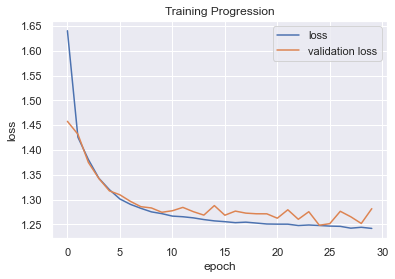

In [92]:
# Plot loss and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','validation loss'])
plt.title('Training Progression')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [94]:
m = tf.keras.metrics.CategoricalCrossentropy()
m.update_state(decoder_otest, preds)
print('Loss on test data: ', float(m.result()))

Loss on test data:  1.222845435142517


# Classification Analysis

In [95]:
y_test.shape

(220726, 7)

In [96]:
# Find accuracy for setup and result pitch
for pitch_seq in [1,2]:    
    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(decoder_otest[:,pitch_seq-1,:], preds[:,pitch_seq-1,:])
    print('Prediction accuracy for pitch {}:'.format(pitch_seq), float(m.result()))

Prediction accuracy for pitch 1: 0.4597834348678589
Prediction accuracy for pitch 2: 0.47852471470832825


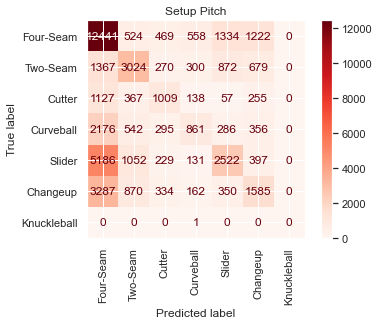

In [97]:
# Build confusion matrices for the setup and result pitch
cm1 = confusion_matrix(decoder_otest[:,0,:].argmax(axis=1), 
                       preds[:,0,:].argmax(axis=1))
cm2 = confusion_matrix(decoder_otest[:,1,:].argmax(axis=1), 
                       preds[:,1,:].argmax(axis=1))

labels = ['Four-Seam', 'Two-Seam', 'Cutter', 'Curveball', 'Slider', 'Changeup', 'Knuckleball']

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=labels)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels)

disp1.plot(cmap=plt.cm.Reds, xticks_rotation='vertical')
plt.title('Setup Pitch')

plt.show()

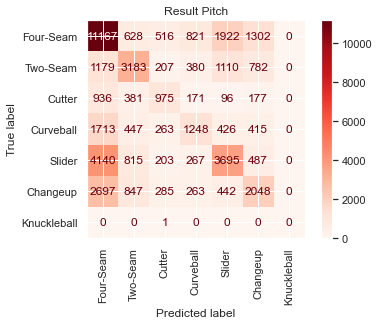

In [98]:
disp2.plot(cmap=plt.cm.Reds, xticks_rotation='vertical')
plt.title('Result Pitch')

plt.show()

In [108]:
print('Four-seam fastball rate on setup:', cm1[0,:].sum()/cm1.sum())
print('Four-seam fastball rate on result:', cm2[0,:].sum()/cm2.sum())

Four-seam fastball rate on setup: 0.35484078481826953
Four-seam fastball rate on result: 0.3507237053715021


## ROC-AUC

The code below is lifted from [here](https://www.kaggle.com/muhammetvarl/mlp-multiclass-classification-roc-auc).

In [100]:
# Process of plotting roc-auc curve belonging to all classes.
from itertools import cycle
sns.set_theme()


def roc_auc_plot(y_true, y_preds, future_pitch_index, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,future_pitch_index,i], y_preds[:,future_pitch_index,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr['micro'], tpr['micro'], _ = roc_curve(y_true[:,future_pitch_index,:].ravel(), y_preds[:,future_pitch_index,:].ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    lw = 2 # line_width

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr['micro'], tpr['micro'],
        label="micro-average ROC curve (area = {0:0.2f})"
            ''.format(roc_auc['micro']),
        color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr['macro'], tpr['macro'],
        label="macro-average ROC curve (area = {0:0.2f})"
            ''.format(roc_auc['macro']),
            color='navy', linestyle=':', linewidth=4)
    
    remap = ['FF', 'FT', 'FC', 'CU', 'SL', 'CH', 'KN']
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'seagreen', 'darkred', 'lawngreen'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class ' + remap[i]+ ' (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    
    if future_pitch_index==0: pitch_seq = 'Setup'
    else: pitch_seq = 'Result'
    
    plt.plot([0,1],[0,1], lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Multi-Class Curve for ' + pitch_seq)
    plt.legend(loc='lower right')
    return plt.show()

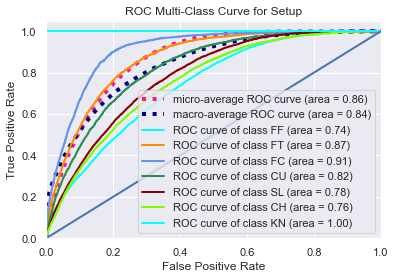

In [101]:
roc_auc_plot(decoder_otest,preds,0,7)

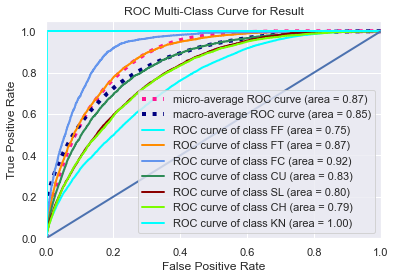

In [102]:
roc_auc_plot(decoder_otest,preds,1,7)

# wOBA

In [103]:
# Find where the prediction matches reality by using an indicator
pred_indicator = np.where(decoder_otest.argmax(axis=2) == preds.argmax(axis=2),1,0)

In [104]:
pred_woba = hstack((pred_indicator,woba_test.reshape(woba_test.shape[0],1)))

In [105]:
print('Number of plate appearances in training set: ', encoder_input.shape[0])
print('Number of plate appearances in test set: ', encoder_test.shape[0])

Number of plate appearances in training set:  85927
Number of plate appearances in test set:  46635


In [106]:
print('PA with both pitches correct:', pred_woba[:,2][(pred_woba[:,0]==1)&(pred_woba[:,1]==1)].shape[0])
print('PA with only set-up correct:', pred_woba[:,2][(pred_woba[:,0]==1)&(pred_woba[:,1]==0)].shape[0])
print('PA with only result correct:', pred_woba[:,2][(pred_woba[:,0]==0)&(pred_woba[:,1]==1)].shape[0])
print('PA with neither correct:', pred_woba[:,2][(pred_woba[:,0]==0)&(pred_woba[:,1]==0)].shape[0])

PA with both pitches correct: 11162
PA with only set-up correct: 10280
PA with only result correct: 11154
PA with neither correct: 14039


In [107]:
print('wOBA with both pitches correct:', pred_woba[:,2][(pred_woba[:,0]==1)&(pred_woba[:,1]==1)].mean())
print('wOBA with only set-up correct:', pred_woba[:,2][(pred_woba[:,0]==1)&(pred_woba[:,1]==0)].mean())
print('wOBA with only result correct:', pred_woba[:,2][(pred_woba[:,0]==0)&(pred_woba[:,1]==1)].mean())
print('wOBA with neither correct:', pred_woba[:,2][(pred_woba[:,0]==0)&(pred_woba[:,1]==0)].mean())

wOBA with both pitches correct: 0.32111180791972765
wOBA with only set-up correct: 0.2889007782101168
wOBA with only result correct: 0.3164201183431953
wOBA with neither correct: 0.29203290832680395
